# loading imports

In [100]:
# =====================================================================
# CORE LIBRARIES
# =====================================================================
import os
import sys
from pathlib import Path

# =====================================================================
# DATA HANDLING
# =====================================================================
import numpy as np
import pandas as pd

# =====================================================================
# STATISTICS & FEATURE ANALYSIS
# =====================================================================
from scipy.stats import (
    spearmanr, mannwhitneyu, chi2_contingency
)
from scipy.stats.contingency import association
from sklearn.feature_selection import mutual_info_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor

# =====================================================================
# PREPROCESSING
# =====================================================================
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# =====================================================================
# VISUALIZATION
# =====================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

In [101]:
# Simple approach - go up two levels from notebooks folder
PROJECT_ROOT = Path.cwd().parent.parent
DATA_DIR = PROJECT_ROOT / 'data'/'raw'
data_file = DATA_DIR / 'raw.parquet'

# Check if file exists
if not data_file.is_file():
    print(f"Error: Dataset not found: {data_file}")
    print(f"Project root: {PROJECT_ROOT}")
    print(f"Data directory: {DATA_DIR}")
   
    raise FileNotFoundError(f"FATAL: Required dataset not found at {data_file}. Please verify path.")

# Load dataset
try:
    df = pd.read_parquet(data_file)
    print(f"Dataset loaded: {data_file}")
except Exception as e:
    print(f"Error reading file: {e}")
    # CORRECTED: Raise a standard Exception if reading fails
    raise IOError(f"FATAL: Error reading Parquet file: {e}")

# Drop 'id' column if present
if 'id' in df.columns:
    df = df.drop(columns='id')

# Display basic info
print(f"Shape: {df.shape}")
print(f"Columns: {', '.join(df.columns)}")
print(f"Missing values: {df.isna().sum().sum()}")
print("\nFirst 5 rows:")
print(df.head())

Dataset loaded: p:\projects\heart_disease_prediction\data\raw\raw.parquet
Shape: (70000, 12)
Columns: age, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active, cardio
Missing values: 0

First 5 rows:
     age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0  18393       2     168    62.0    110     80            1     1      0   
1  20228       1     156    85.0    140     90            3     1      0   
2  18857       1     165    64.0    130     70            3     1      0   
3  17623       2     169    82.0    150    100            1     1      0   
4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  


In [102]:
# drop id column if exists
if 'id' in df.columns:
    df=df.drop(columns='id')
print("Dropped 'id' column.")

# verfiy id column is dropped
if 'id' in df.columns:
    raise ValueError("'id' column was not dropped successfully.")

# drop the duplicates records
df=df.drop_duplicates().reset_index(drop=True)
df.shape 

Dropped 'id' column.


(69976, 12)

In [103]:
# Show columns names
df.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [104]:
#  column renaming
column_mapping = {
    'age': 'Age',
    'gender': 'Sex',
    'height': 'Height',
    'weight': 'Weight',
    'ap_hi': 'Systolic_BP',
    'ap_lo': 'Diastolic_BP',
    'cholesterol': 'Cholesterol_Level',
    'gluc': 'Glucose_Level',
    'smoke': 'Smoking_Status',
    'alco': 'Alcohol_Intake',
    'active': 'Physical_Activity',
    'cardio': 'target'
}
df = df.rename(columns={k: v for k, v in column_mapping.items() if k in df.columns})
df.columns  # Show column names after renaming

Index(['Age', 'Sex', 'Height', 'Weight', 'Systolic_BP', 'Diastolic_BP',
       'Cholesterol_Level', 'Glucose_Level', 'Smoking_Status',
       'Alcohol_Intake', 'Physical_Activity', 'target'],
      dtype='object')

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69976 entries, 0 to 69975
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                69976 non-null  int64  
 1   Sex                69976 non-null  int64  
 2   Height             69976 non-null  int64  
 3   Weight             69976 non-null  float64
 4   Systolic_BP        69976 non-null  int64  
 5   Diastolic_BP       69976 non-null  int64  
 6   Cholesterol_Level  69976 non-null  int64  
 7   Glucose_Level      69976 non-null  int64  
 8   Smoking_Status     69976 non-null  int64  
 9   Alcohol_Intake     69976 non-null  int64  
 10  Physical_Activity  69976 non-null  int64  
 11  target             69976 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.4 MB


In [106]:
# Create mapping dictionaries
mapping_dict = {
    'Sex': {1: 'Male', 2: 'Female'},
    'Cholesterol_Level': {1: 'Normal', 2: 'Borderline High', 3: 'High'},
    'Glucose_Level': {1: 'Normal', 2: 'Prediabetes', 3: 'Diabetes'},
    'Smoking_Status': {0: 'Non-Smoker', 1: 'Smoker'},
    'Alcohol_Intake': {0: 'No/Rarely', 1: 'Yes/Regularly'},
    'Physical_Activity': {0: 'Inactive/Low', 1: 'Active'},
    'target': {0: 'No Disease', 1: 'Disease'}
}

# Apply mappings IN-PLACE to the original columns and set the correct dtype
for col, mapping in mapping_dict.items():
    if col in df.columns:
        # Update the column directly
        df[col] = df[col].map(mapping)
        # Set the column to be a categorical dtype
        df[col] = df[col].astype('category')

print("✓ Mappings applied in-place and categorical dtypes set")

# Define other column type conversions
categorical_cols = ['Sex','target','Cholesterol_Level','Glucose_Level','Smoking_Status',
                    'Alcohol_Intake', 'Physical_Activity']  

float_cols = ['Height', 'Weight']

num_cols = ['Age','Systolic_BP', 'Diastolic_BP']

# Convert categorical columns (already done above, but ensure they're categorical)
for col in categorical_cols:
    if col in df.columns and col not in mapping_dict.keys():  # Only if not already processed
        df[col] = df[col].astype('category')
        print(f"Converted {col} to category type")

# Convert float columns - handle missing values properly
for col in float_cols:
    if col in df.columns:
        # 'coerce' will turn any non-numeric values into NaN (missing)
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # No need for astype(float) since to_numeric already returns float
        print(f"Converted {col} to float type")

# Convert integer columns - handle NaN values correctly
for col in num_cols:
    if col in df.columns:
        # First convert to numeric with coercion for invalid values
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # Then convert to integer, but only for non-NaN values
        # This avoids the error when trying to convert NaN to int
        mask = df[col].notna()
        if mask.all():
            df[col] = df[col].astype(int)
        else:
            # Keep NaN values as is, convert only valid values to int
            df.loc[mask, col] = df.loc[mask, col].astype(int)
        print(f"Converted {col} to integer type (with NaN handling)")

# Print unique value counts for all categorical columns
print("\n" + "="*50)
print("UNIQUE VALUE COUNTS FOR CATEGORICAL COLUMNS")
print("="*50)

all_categorical_cols = list(mapping_dict.keys()) + [col for col in categorical_cols if col not in mapping_dict.keys()]

for col in all_categorical_cols:
    if col in df.columns and df[col].dtype.name == 'category':
        print(f"\n{col}:")
        value_counts = df[col].value_counts(dropna=False)
        for value, count in value_counts.items():
            print(f"  {value}: {count}")
        print(f"  Total unique values: {len(value_counts)}")

df.info()

✓ Mappings applied in-place and categorical dtypes set
Converted Height to float type
Converted Weight to float type
Converted Age to integer type (with NaN handling)
Converted Systolic_BP to integer type (with NaN handling)
Converted Diastolic_BP to integer type (with NaN handling)

UNIQUE VALUE COUNTS FOR CATEGORICAL COLUMNS

Sex:
  Male: 45509
  Female: 24467
  Total unique values: 2

Cholesterol_Level:
  Normal: 52361
  Borderline High: 9549
  High: 8066
  Total unique values: 3

Glucose_Level:
  Normal: 59455
  Diabetes: 5331
  Prediabetes: 5190
  Total unique values: 3

Smoking_Status:
  Non-Smoker: 63807
  Smoker: 6169
  Total unique values: 2

Alcohol_Intake:
  No/Rarely: 66212
  Yes/Regularly: 3764
  Total unique values: 2

Physical_Activity:
  Active: 56241
  Inactive/Low: 13735
  Total unique values: 2

target:
  No Disease: 35004
  Disease: 34972
  Total unique values: 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69976 entries, 0 to 69975
Data columns (total 12 colum

In [107]:
df.describe()

,Age,Height,Weight,Systolic_BP,Diastolic_BP
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,19468.950126,164.359152,74.208519,128.820453,96.636261
std,2467.374620,8.211218,14.397211,154.037729,188.504581
min,10798.000000,55.000000,10.000000,-150.000000,-70.000000
25%,17664.000000,159.000000,65.000000,120.000000,80.000000
50%,19703.000000,165.000000,72.000000,120.000000,80.000000
75%,21327.000000,170.000000,82.000000,140.000000,90.000000
max,23713.000000,250.000000,200.000000,16020.000000,11000.000000


performing validation primarily by considering these specific, impossible values from your raw data summary:

* **For `Systolic_BP`:** The `min` of **-150** and the `max` of **16,020**.
* **For `Diastolic_BP`:** The `min` of **-70** and the `max` of **11,000**.
* **For `Height_mt`:** The `min` of **0.55**.
* **For `Weight`:** The `min` of **10**.

These values are physiologically impossible and represent clear data errors that must be corrected before any analysis can be done.

### Data Preprocessing: Clinical Range Validation and Correction

### BloodPressure cleaning

In [108]:
# ==============================================================
# BLOOD PRESSURE CLEANING
# ==============================================================

systolic_col, diastolic_col = 'Systolic_BP', 'Diastolic_BP'

if systolic_col in df.columns and diastolic_col in df.columns:
        
    print(f"\n[INITIAL STATE]")
    print(f"  Systolic range: {df[systolic_col].min():.0f} - {df[systolic_col].max():.0f} mmHg")
    print(f"  Diastolic range: {df[diastolic_col].min():.0f} - {df[diastolic_col].max():.0f} mmHg")
    print(f"  Systolic nulls: {df[systolic_col].isna().sum()}")
    print(f"  Diastolic nulls: {df[diastolic_col].isna().sum()}")
    
    # STEP 1: Convert to numeric
    df[systolic_col] = pd.to_numeric(df[systolic_col], errors='coerce')
    df[diastolic_col] = pd.to_numeric(df[diastolic_col], errors='coerce')
    print(f"\n[STEP 1] ✓ Converted to numeric")
    
    # STEP 2: Remove negative values AND zeros
    invalid_sys = ((df[systolic_col] <= 0) | (df[systolic_col] < 0)) & df[systolic_col].notna()
    invalid_dia = ((df[diastolic_col] <= 0) | (df[diastolic_col] < 0)) & df[diastolic_col].notna()
    df.loc[invalid_sys, systolic_col] = np.nan
    df.loc[invalid_dia, diastolic_col] = np.nan
    print(f"[STEP 2] Removed {invalid_sys.sum()} invalid systolic (≤0), {invalid_dia.sum()} invalid diastolic (≤0)")
    
    # STEP 3: Fix magnitude errors
    # 3a. Extreme typos (≥1000) → ÷10
    sys_extreme = (df[systolic_col] >= 1000) & df[systolic_col].notna()
    dia_extreme = (df[diastolic_col] >= 1000) & df[diastolic_col].notna()
    
    extreme_sys_count = sys_extreme.sum()
    extreme_dia_count = dia_extreme.sum()
    
    if sys_extreme.any():
        fixable_sys = sys_extreme & ((df[systolic_col] / 10).between(70, 250))
        df.loc[fixable_sys, systolic_col] /= 10
        df.loc[sys_extreme & ~fixable_sys, systolic_col] = np.nan
    
    if dia_extreme.any():
        fixable_dia = dia_extreme & ((df[diastolic_col] / 10).between(40, 150))
        df.loc[fixable_dia, diastolic_col] /= 10
        df.loc[dia_extreme & ~fixable_dia, diastolic_col] = np.nan
    
    # 3b. Decimal errors (300-999) → ÷10
    sys_dec = df[systolic_col].between(300, 999)
    dia_dec = df[diastolic_col].between(300, 999)
    
    dec_sys_count = sys_dec.sum()
    dec_dia_count = dia_dec.sum()
    
    if sys_dec.any():
        fixable_sys_dec = sys_dec & ((df[systolic_col] / 10).between(70, 150))
        df.loc[fixable_sys_dec, systolic_col] /= 10
        df.loc[sys_dec & ~fixable_sys_dec, systolic_col] = np.nan
    
    if dia_dec.any():
        fixable_dia_dec = dia_dec & ((df[diastolic_col] / 10).between(40, 90))
        df.loc[fixable_dia_dec, diastolic_col] /= 10
        df.loc[dia_dec & ~fixable_dia_dec, diastolic_col] = np.nan
    
    # 3c. Single digit (1-9) → ×10
    sys_single = df[systolic_col].between(1, 9)
    dia_single = df[diastolic_col].between(1, 9)
    
    single_sys_count = sys_single.sum()
    single_dia_count = dia_single.sum()
    
    if sys_single.any():
        fixable_sys_single = sys_single & ((df[systolic_col] * 10).between(70, 90))
        df.loc[fixable_sys_single, systolic_col] *= 10
        df.loc[sys_single & ~fixable_sys_single, systolic_col] = np.nan
    
    if dia_single.any():
        fixable_dia_single = dia_single & ((df[diastolic_col] * 10).between(40, 90))
        df.loc[fixable_dia_single, diastolic_col] *= 10
        df.loc[dia_single & ~fixable_dia_single, diastolic_col] = np.nan
    
    print(f"[STEP 3] Fixed magnitude errors:")
    print(f"         Extreme (≥1000): {extreme_sys_count} systolic, {extreme_dia_count} diastolic")
    print(f"         Decimal (300-999): {dec_sys_count} systolic, {dec_dia_count} diastolic")
    print(f"         Single digit (1-9): {single_sys_count} systolic, {single_dia_count} diastolic")
    
    # STEP 4: Swap inverted pairs
    valid_pairs = df[systolic_col].notna() & df[diastolic_col].notna()
    swap_mask = valid_pairs & (df[systolic_col] < df[diastolic_col])
    
    if swap_mask.any():
        temp = df.loc[swap_mask, systolic_col].copy()
        df.loc[swap_mask, systolic_col] = df.loc[swap_mask, diastolic_col]
        df.loc[swap_mask, diastolic_col] = temp
        print(f"[STEP 4] Swapped {swap_mask.sum()} inverted pairs")
    else:
        print(f"[STEP 4] ✓ No inverted pairs")
    
    # STEP 5: Apply physiological limits (CORRECTED - catches all low values)
    sys_low = (df[systolic_col] < 70) & df[systolic_col].notna()  # Changed from between(10, 69)
    sys_high = (df[systolic_col] > 250) & df[systolic_col].notna()
    dia_low = (df[diastolic_col] < 40) & df[diastolic_col].notna()  # Changed from between(10, 39)
    dia_high = (df[diastolic_col] > 150) & df[diastolic_col].notna()
    
    removed_sys = sys_low.sum() + sys_high.sum()
    removed_dia = dia_low.sum() + dia_high.sum()
    
    df.loc[sys_low | sys_high, systolic_col] = np.nan
    df.loc[dia_low | dia_high, diastolic_col] = np.nan
    print(f"[STEP 5] Applied physiological limits (70-250 systolic, 40-150 diastolic)")
    print(f"         Removed {removed_sys} systolic, {removed_dia} diastolic")
    
    # SUMMARY
    print(f"\n{'='*75}")
    print(" CLEANING COMPLETE")
    print(f"{'='*75}")
    print(f"Systolic: {df[systolic_col].min():.0f}-{df[systolic_col].max():.0f} mmHg (mean: {df[systolic_col].mean():.1f})")
    print(f"Diastolic: {df[diastolic_col].min():.0f}-{df[diastolic_col].max():.0f} mmHg (mean: {df[diastolic_col].mean():.1f})")
    print(f"Valid pairs: {(df[systolic_col].notna() & df[diastolic_col].notna()).sum():,}")
    print(f"Missing systolic: {df[systolic_col].isna().sum():,}")
    print(f"Missing diastolic: {df[diastolic_col].isna().sum():,}")
    print(f"{'='*75}\n")

else:
    print("❌ Error: Systolic_BP and/or Diastolic_BP columns not found")


[INITIAL STATE]
  Systolic range: -150 - 16020 mmHg
  Diastolic range: -70 - 11000 mmHg
  Systolic nulls: 0
  Diastolic nulls: 0

[STEP 1] ✓ Converted to numeric
[STEP 2] Removed 7 invalid systolic (≤0), 22 invalid diastolic (≤0)
[STEP 3] Fixed magnitude errors:
         Extreme (≥1000): 24 systolic, 921 diastolic
         Decimal (300-999): 16 systolic, 32 diastolic
         Single digit (1-9): 3 systolic, 8 diastolic
[STEP 4] Swapped 277 inverted pairs
[STEP 5] Applied physiological limits (70-250 systolic, 40-150 diastolic)
         Removed 14 systolic, 208 diastolic

 CLEANING COMPLETE
Systolic: 70-240 mmHg (mean: 127.0)
Diastolic: 40-150 mmHg (mean: 81.6)
Valid pairs: 69,695
Missing systolic: 34
Missing diastolic: 262



### Height cleaning

In [109]:
# ==============================================================
#  HEIGHT CLEANING
# ==============================================================
height_col = 'Height'

if height_col in df.columns:
    
    print("="*70)
    print(" HEIGHT CLEANING PIPELINE")
    print("="*70)
    
    print(f"\n[INITIAL STATE]")
    print(f"  Height range: {df[height_col].min():.1f} - {df[height_col].max():.1f}")
    print(f"  Height nulls: {df[height_col].isna().sum()}")
    
    # STEP 1: Convert to numeric
    df[height_col] = pd.to_numeric(df[height_col], errors='coerce')
    
    # STEP 2: Identify and nullify invalid values (≤ 0)
    print(f"\n[STEP 1: Identifying Invalid Values]")
    negative_or_zero = (df[height_col] <= 0) & df[height_col].notna()
    if negative_or_zero.any():
        df.loc[negative_or_zero, height_col] = np.nan
        print(f"  Nullified {negative_or_zero.sum()} height values ≤ 0")
    else:
        print(f"  ✓ No invalid values (≤ 0) found")
    
    # STEP 3: Fix magnitude errors (keep as NaN if unfixable)
    print(f"\n[STEP 2: Fixing Magnitude Errors]")
    
    # Heights in METERS (1.0 - 2.5 m) → convert to cm
    meter_mask = df[height_col].between(1.0, 2.5)
    if meter_mask.any():
        df.loc[meter_mask, height_col] *= 100
        print(f"  Converted {meter_mask.sum()} heights from meters to cm (× 100)")
    else:
        print(f"  ✓ No heights in meters found")
    
    # Heights in MM (1000-2500 mm) → convert to cm
    mm_mask = df[height_col].between(1000, 2500)
    if mm_mask.any():
        df.loc[mm_mask, height_col] /= 10
        print(f"  Converted {mm_mask.sum()} heights from mm to cm (÷ 10)")
    else:
        print(f"  ✓ No heights in mm found")
    
    # Decimal point errors (300-999) → try to fix, else NaN
    decimal_errors = df[height_col].between(300, 999)
    if decimal_errors.any():
        # Check if dividing by 10 gives valid range
        fixable = decimal_errors & ((df[height_col] / 10).between(130, 230))
        df.loc[fixable, height_col] /= 10
        df.loc[decimal_errors & ~fixable, height_col] = np.nan
        print(f"  Fixed {fixable.sum()} decimal errors (300-999 → ÷10)")
        print(f"  Nullified {(decimal_errors & ~fixable).sum()} unfixable values")
    
    # STEP 4: Nullify values outside physiological limits (keep as NaN)
    print(f"\n[STEP 3: Applying Physiological Limits]")
    
    # Valid adult height range: 130-230 cm (4'3" to 7'7")
    # Values outside this range → NaN (will be imputed later)
    too_short = (df[height_col] < 130) & df[height_col].notna()
    too_tall = (df[height_col] > 230) & df[height_col].notna()
    
    df.loc[too_short, height_col] = np.nan
    df.loc[too_tall, height_col] = np.nan
    
    print(f"  Nullified {too_short.sum()} heights < 130 cm (will be imputed)")
    print(f"  Nullified {too_tall.sum()} heights > 230 cm (will be imputed)")
    
    # SUMMARY
    print(f"\n{'='*70}")
    print(" CLEANING SUMMARY")
    print(f"{'='*70}")
    
    height_valid = df[height_col].notna()
    
    print(f"\nFinal Statistics:")
    if height_valid.any():
        print(f"  Height range: {df[height_col].min():.1f} - {df[height_col].max():.1f} cm")
        print(f"  Height mean: {df[height_col].mean():.1f} cm")
        print(f"  Height median: {df[height_col].median():.1f} cm")
        print(f"  Height std: {df[height_col].std():.1f} cm")
    else:
        print("  No valid height values remain")
    
    print(f"\nMissing Values (to be imputed):")
    print(f"  Height nulls: {df[height_col].isna().sum()} ({df[height_col].isna().mean()*100:.1f}%)")
    
    print(f"\nData Quality:")
    print(f"  Valid records: {height_valid.sum()} ({height_valid.mean()*100:.1f}%)")
    print(f"  Missing records: {(~height_valid).sum()} ({(~height_valid).mean()*100:.1f}%)")
    
    if height_valid.any():
        # Final validation check
        if df[height_col].min() >= 130 and df[height_col].max() <= 230:
            print(f"\n✅ All valid heights within clinical range (130-230 cm)!")
            print(f"✅ Invalid values marked as NaN for imputation")
        else:
            print(f"\n⚠ Some extreme values present")
    
    print(f"\n{'='*70}\n")

else:
    print("❌ Error: Height column not found in DataFrame")

 HEIGHT CLEANING PIPELINE

[INITIAL STATE]
  Height range: 55.0 - 250.0
  Height nulls: 0

[STEP 1: Identifying Invalid Values]
  ✓ No invalid values (≤ 0) found

[STEP 2: Fixing Magnitude Errors]
  ✓ No heights in meters found
  ✓ No heights in mm found

[STEP 3: Applying Physiological Limits]
  Nullified 92 heights < 130 cm (will be imputed)
  Nullified 1 heights > 230 cm (will be imputed)

 CLEANING SUMMARY

Final Statistics:
  Height range: 130.0 - 207.0 cm
  Height mean: 164.4 cm
  Height median: 165.0 cm
  Height std: 7.9 cm

Missing Values (to be imputed):
  Height nulls: 93 (0.1%)

Data Quality:
  Valid records: 69883 (99.9%)
  Missing records: 93 (0.1%)

✅ All valid heights within clinical range (130-230 cm)!
✅ Invalid values marked as NaN for imputation




### Weight cleaning

In [110]:
# ==============================================================
# WEIGHT CLEANING
# ==============================================================
weight_col = 'Weight'

if weight_col in df.columns:
    
    print("="*70)
    print(" WEIGHT CLEANING PIPELINE")
    print("="*70)
    
    print(f"\n[INITIAL STATE]")
    print(f"  Weight range: {df[weight_col].min():.1f} - {df[weight_col].max():.1f} kg")
    print(f"  Weight nulls: {df[weight_col].isna().sum()}")
    
    # STEP 1: Convert to numeric
    df[weight_col] = pd.to_numeric(df[weight_col], errors='coerce')
    
    # STEP 2: Identify and nullify invalid values (≤ 0)
    print(f"\n[STEP 1: Identifying Invalid Values]")
    negative_or_zero = (df[weight_col] <= 0) & df[weight_col].notna()
    if negative_or_zero.any():
        df.loc[negative_or_zero, weight_col] = np.nan
        print(f"  Nullified {negative_or_zero.sum()} weight values ≤ 0")
    else:
        print(f"  ✓ No invalid values (≤ 0) found")
    
    # STEP 3: Fix magnitude errors (keep as NaN if unfixable)
    print(f"\n[STEP 2: Fixing Magnitude Errors]")
    
    # Weights > 500 kg (typos with extra digits)
    large_weight = (df[weight_col] > 500) & df[weight_col].notna()
    if large_weight.any():
        fixable = large_weight & ((df[weight_col] / 10).between(40, 300))
        df.loc[fixable, weight_col] /= 10
        df.loc[large_weight & ~fixable, weight_col] = np.nan
        print(f"  Fixed {fixable.sum()} large weights (÷10)")
        print(f"  Nullified {(large_weight & ~fixable).sum()} unfixable large weights")
    else:
        print(f"  ✓ No large weight typos found")
    
    # Decimal point errors (301-999) → divide by 10
    decimal_errors = df[weight_col].between(301, 999)
    if decimal_errors.any():
        fixable_dec = decimal_errors & ((df[weight_col] / 10).between(40, 99))
        df.loc[fixable_dec, weight_col] /= 10
        df.loc[decimal_errors & ~fixable_dec, weight_col] = np.nan
        print(f"  Fixed {fixable_dec.sum()} decimal errors (301-999 → ÷10)")
        print(f"  Nullified {(decimal_errors & ~fixable_dec).sum()} unfixable values")
    
    # STEP 4: Nullify values outside physiological limits (keep as NaN)
    print(f"\n[STEP 3: Applying Physiological Limits]")
    
    # Weight limits for adults 30+ years: 40-300 kg
    # 40 kg = 88 lbs (severe underweight but survivable for adults)
    # 300 kg = 661 lbs (extreme obesity but documented)
    too_light = (df[weight_col] < 40) & df[weight_col].notna()
    too_heavy = (df[weight_col] > 300) & df[weight_col].notna()
    
    df.loc[too_light, weight_col] = np.nan
    df.loc[too_heavy, weight_col] = np.nan
    
    print(f"  Nullified {too_light.sum()} weights < 40 kg (will be imputed)")
    print(f"  Nullified {too_heavy.sum()} weights > 300 kg (will be imputed)")
    
    # SUMMARY
    print(f"\n{'='*70}")
    print(" CLEANING SUMMARY")
    print(f"{'='*70}")
    
    weight_valid = df[weight_col].notna()
    
    print(f"\nFinal Statistics:")
    if weight_valid.any():
        print(f"  Weight range: {df[weight_col].min():.1f} - {df[weight_col].max():.1f} kg")
        print(f"  Weight mean: {df[weight_col].mean():.1f} kg")
        print(f"  Weight median: {df[weight_col].median():.1f} kg")
        print(f"  Weight std: {df[weight_col].std():.1f} kg")
    else:
        print("  No valid weight values remain")
    
    print(f"\nMissing Values (to be imputed):")
    print(f"  Weight nulls: {df[weight_col].isna().sum()} ({df[weight_col].isna().mean()*100:.1f}%)")
    
    print(f"\nData Quality:")
    print(f"  Valid records: {weight_valid.sum()} ({weight_valid.mean()*100:.1f}%)")
    print(f"  Missing records: {(~weight_valid).sum()} ({(~weight_valid).mean()*100:.1f}%)")
    
    if weight_valid.any():
        if df[weight_col].min() >= 40 and df[weight_col].max() <= 300:
            print(f"\n✅ All valid weights within clinical range (40-300 kg)!")
            print(f"✅ Invalid values marked as NaN for imputation")
        else:
            print(f"\n⚠ Some extreme values present")
    
    print(f"\n{'='*70}\n")

else:
    print("❌ Error: Weight column not found in DataFrame")

 WEIGHT CLEANING PIPELINE

[INITIAL STATE]
  Weight range: 10.0 - 200.0 kg
  Weight nulls: 0

[STEP 1: Identifying Invalid Values]
  ✓ No invalid values (≤ 0) found

[STEP 2: Fixing Magnitude Errors]
  ✓ No large weight typos found

[STEP 3: Applying Physiological Limits]
  Nullified 52 weights < 40 kg (will be imputed)
  Nullified 0 weights > 300 kg (will be imputed)

 CLEANING SUMMARY

Final Statistics:
  Weight range: 40.0 - 200.0 kg
  Weight mean: 74.2 kg
  Weight median: 72.0 kg
  Weight std: 14.4 kg

Missing Values (to be imputed):
  Weight nulls: 52 (0.1%)

Data Quality:
  Valid records: 69924 (99.9%)
  Missing records: 52 (0.1%)

✅ All valid weights within clinical range (40-300 kg)!
✅ Invalid values marked as NaN for imputation




### age convertion (days -> years)

In [111]:
# One-liner conversion with min/max display
df['Age_Years'] = df['Age'] / 365.25
df['Age_Years'] = df['Age_Years'].where((df['Age_Years'] >= 0) & (df['Age_Years'] <= 120))

df= df.drop(columns='Age')

print(f"Age range: {df['Age_Years'].min():.1f} - {df['Age_Years'].max():.1f} years")

Age range: 29.6 - 64.9 years


In [112]:
df.describe()

,Height,Weight,Systolic_BP,Diastolic_BP,Age_Years
count,69883.000000,69924.000000,69942.000000,69714.000000,69976.000000
mean,164.438991,74.238500,126.963513,81.579311,53.303080
std,7.859999,14.359458,17.166399,9.696196,6.755304
min,130.000000,40.000000,70.000000,40.000000,29.563313
25%,159.000000,65.000000,120.000000,80.000000,48.361396
50%,165.000000,72.000000,120.000000,80.000000,53.943874
75%,170.000000,82.000000,140.000000,90.000000,58.390144
max,207.000000,200.000000,240.000000,150.000000,64.922656


In [113]:
df.isna().sum()

Sex                    0
Height                93
Weight                52
Systolic_BP           34
Diastolic_BP         262
Cholesterol_Level      0
Glucose_Level          0
Smoking_Status         0
Alcohol_Intake         0
Physical_Activity      0
target                 0
Age_Years              0
dtype: int64

### correcting all the error values based on clinical range and validating again

In [114]:
# ==============================================================
# MICE IMPUTATION WITH CATEGORICAL TEXT LABELS (NO WARNINGS)
# ==============================================================

import numpy as np
import pandas as pd
import warnings
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder

# Suppress pandas FutureWarnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

print("="*75)
print(" MICE IMPUTATION (Preserving Categorical Text Labels)")
print("="*75)

# ==============================================================
# STEP 1: IDENTIFY COLUMN TYPES
# ==============================================================

print("\n" + "="*75)
print("STEP 1: IDENTIFYING COLUMN TYPES")
print("="*75)

# Identify categorical (text) columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"\nCategorical columns ({len(categorical_cols)}):")
for col in categorical_cols:
    unique_vals = df[col].dropna().unique()
    print(f"  {col}: {list(unique_vals)[:5]}")

# Identify numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nNumeric columns ({len(numeric_cols)}):")
print(f"  {', '.join(numeric_cols)}")

# ==============================================================
# STEP 2: CLINICAL RANGE VALIDATION
# ==============================================================

# Updated ranges: Weight 40-300 kg, Height 130-230 cm, Age 30-100 years
CLINICAL_RANGES = {
    'Height': (130, 230),
    'Weight': (40, 300),
    'Systolic_BP': (70, 250),
    'Diastolic_BP': (40, 150),
    'Age_Years': (30, 100),
}

print("\n" + "="*75)
print("STEP 2: CLINICAL RANGE VALIDATION")
print("="*75)

print("\nApplying range validation...")
for col, (min_val, max_val) in CLINICAL_RANGES.items():
    if col in df.columns:
        below_min = (df[col] < min_val) & df[col].notna()
        above_max = (df[col] > max_val) & df[col].notna()
        total_invalid = below_min.sum() + above_max.sum()
        
        if total_invalid > 0:
            df.loc[below_min | above_max, col] = np.nan
            print(f"  {col}: Set {total_invalid} out-of-range to NaN "
                  f"({below_min.sum()} < {min_val}, {above_max.sum()} > {max_val})")
        else:
            print(f"  {col}: ✓ All in range [{min_val}, {max_val}]")

# ==============================================================
# STEP 3: ENCODE CATEGORICAL COLUMNS FOR MICE
# ==============================================================

print("\n" + "="*75)
print("STEP 3: TEMPORARILY ENCODING CATEGORICAL COLUMNS")
print("="*75)

# Store encoders and create encoded columns
label_encoders = {}
encoded_col_names = []

if len(categorical_cols) > 0:
    print("\nEncoding categorical text to numbers (temporary)...")
    
    for col in categorical_cols:
        le = LabelEncoder()
        non_null_mask = df[col].notna()
        
        if non_null_mask.sum() > 0:
            # Fit encoder
            le.fit(df.loc[non_null_mask, col])
            
            # Create new encoded column (FIXED - direct assignment)
            encoded_col = col + '_encoded'
            
            # Initialize with NaN (using numpy array)
            encoded_array = np.full(len(df), np.nan)
            encoded_array[non_null_mask] = le.transform(df.loc[non_null_mask, col])
            
            # Assign directly to avoid pandas warning
            df[encoded_col] = encoded_array
            
            label_encoders[col] = le
            encoded_col_names.append(encoded_col)
            
            print(f"  {col} → {encoded_col}")
            print(f"    Classes ({len(le.classes_)}): {list(le.classes_)}")
    
    print(f"\n✓ Created {len(encoded_col_names)} encoded columns")
else:
    print("\n✓ No categorical columns to encode")

# ==============================================================
# STEP 4: PREPARE ALL COLUMNS FOR MICE
# ==============================================================

print("\n" + "="*75)
print("STEP 4: PREPARING FULL DATASET FOR MICE")
print("="*75)

# All columns for MICE
all_cols_for_mice = numeric_cols + encoded_col_names

print(f"\nTotal columns for MICE: {len(all_cols_for_mice)}")
print(f"  - Original numeric: {len(numeric_cols)}")
print(f"  - Encoded categorical: {len(encoded_col_names)}")

# Show missing data
print("\nMissing data summary:")
missing_summary = df[all_cols_for_mice].isna().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
if len(missing_summary) > 0:
    for col, count in missing_summary.items():
        print(f"  {col}: {count} ({count/len(df)*100:.2f}%)")
else:
    print("  ✓ No missing values")

# ==============================================================
# STEP 5: CONFIGURE MICE CONSTRAINTS (FIXED ORDER!)
# ==============================================================

print("\n" + "="*75)
print("STEP 5: CONFIGURING MICE CONSTRAINTS")
print("="*75)

# CRITICAL: Create min/max arrays in EXACT order of all_cols_for_mice
min_values = []
max_values = []

print("\nConstraints (by column index and order):")
for i, col in enumerate(all_cols_for_mice):
    # Clinical numeric variables
    if col in CLINICAL_RANGES:
        min_val, max_val = CLINICAL_RANGES[col]
        min_values.append(min_val)
        max_values.append(max_val)
        print(f"  [{i:2d}] {col:<30s} -> [{min_val:>6}, {max_val:>6}]")
    
    # Encoded categorical variables
    elif col in encoded_col_names:
        original_col = col.replace('_encoded', '')
        if original_col in label_encoders:
            le = label_encoders[original_col]
            n_classes = len(le.classes_)
            min_values.append(0)
            max_values.append(n_classes - 1)
            print(f"  [{i:2d}] {col:<30s} -> [{0:>6}, {n_classes - 1:>6}] ({n_classes} classes)")
        else:
            min_values.append(-np.inf)
            max_values.append(np.inf)
            print(f"  [{i:2d}] {col:<30s} -> [  -inf,    inf]")
    
    # Other numeric columns (no constraints)
    else:
        min_values.append(-np.inf)
        max_values.append(np.inf)
        print(f"  [{i:2d}] {col:<30s} -> [  -inf,    inf]")

# Convert to numpy arrays
min_values = np.array(min_values)
max_values = np.array(max_values)

# Validation
print(f"\n✓ Constraint arrays created:")
print(f"   - Array length: {len(min_values)}")
print(f"   - Column count: {len(all_cols_for_mice)}")
print(f"   - Match: {'✓ YES' if len(min_values) == len(all_cols_for_mice) else '✗ NO - ERROR!'}")

# ==============================================================
# STEP 6: MICE IMPUTATION
# ==============================================================

print("\n" + "="*75)
print("STEP 6: MICE IMPUTATION")
print("="*75)

print("\nConfiguring MICE imputer...")
print("  - Using ALL features (numeric + encoded categorical)")
print("  - Learning relationships across all variables")
print("  - Constraining to valid ranges")

# Create MICE imputer with ARRAY constraints
mice_imputer = IterativeImputer(
    max_iter=10,
    random_state=42,
    initial_strategy='median',
    min_value=min_values,  # ARRAY in correct order!
    max_value=max_values,  # ARRAY in correct order!
    verbose=0
)

print("\nApplying MICE imputation...")
original_missing = df[all_cols_for_mice].isna().sum().sum()

# Apply MICE
df[all_cols_for_mice] = mice_imputer.fit_transform(df[all_cols_for_mice])

print(f"✓ MICE imputation complete!")
print(f"  Imputed {original_missing} missing values")

# ==============================================================
# STEP 7: DECODE CATEGORICAL COLUMNS BACK TO TEXT
# ==============================================================

print("\n" + "="*75)
print("STEP 7: DECODING CATEGORICAL COLUMNS TO TEXT")
print("="*75)

if len(encoded_col_names) > 0:
    print("\nDecoding back to original text labels...")
    
    for col in categorical_cols:
        encoded_col = col + '_encoded'
        
        if encoded_col in df.columns and col in label_encoders:
            le = label_encoders[col]
            
            # Round to nearest integer
            df[encoded_col] = df[encoded_col].round().astype(int)
            
            # Clip to valid range
            df[encoded_col] = df[encoded_col].clip(0, len(le.classes_) - 1)
            
            # Decode back to text
            df[col] = le.inverse_transform(df[encoded_col])
            
            print(f"  {encoded_col} → {col}")
            print(f"    Classes: {list(le.classes_)}")
            
            # Drop temporary encoded column
            df = df.drop(columns=[encoded_col])
    
    print(f"\n✓ All categorical columns decoded to text")
else:
    print("\n✓ No categorical columns to decode")

# ==============================================================
# STEP 8: POST-IMPUTATION VALIDATION
# ==============================================================

print("\n" + "="*75)
print("STEP 8: POST-IMPUTATION VALIDATION")
print("="*75)

print("\nMissing values AFTER imputation:")
total_missing = df.isna().sum().sum()
if total_missing == 0:
    print("  ✓ All missing values imputed!")
else:
    print(f"  ⚠ Remaining: {total_missing}")

print("\nValidating clinical variables:")
for col, (min_val, max_val) in CLINICAL_RANGES.items():
    if col in df.columns:
        actual_min = df[col].min()
        actual_max = df[col].max()
        in_range = (actual_min >= min_val) and (actual_max <= max_val)
        status = "✓" if in_range else "⚠"
        print(f"  {col}: {actual_min:.1f} - {actual_max:.1f} {status} (expected: [{min_val}, {max_val}])")

print("\nValidating categorical variables:")
for col in categorical_cols:
    if col in df.columns:
        unique_vals = df[col].unique()
        print(f"  {col}: {list(unique_vals)}")

# ==============================================================
# STEP 9: FINAL SAFETY CLIP
# ==============================================================

print("\n" + "="*75)
print("STEP 9: FINAL SAFETY CLIP")
print("="*75)

clipped_count = 0
for col, (min_val, max_val) in CLINICAL_RANGES.items():
    if col in df.columns:
        before = df[col].copy()
        df[col] = df[col].clip(lower=min_val, upper=max_val)
        clipped = (df[col] != before).sum()
        if clipped > 0:
            print(f"  {col}: Clipped {clipped} values to [{min_val}, {max_val}]")
            clipped_count += clipped

if clipped_count == 0:
    print("  ✓ No clipping needed - all values within bounds")

# ==============================================================
# FINAL SUMMARY
# ==============================================================

print("\n" + "="*75)
print(" IMPUTATION COMPLETE")
print("="*75)

print(f"\nDataset shape: {df.shape}")
print(f"Total missing values: {df.isna().sum().sum()}")

print("\nFinal statistics (clinical variables):")
clinical_cols = [col for col in CLINICAL_RANGES.keys() if col in df.columns]
if clinical_cols:
    print(df[clinical_cols].describe().round(2))

print("\nFinal distributions (categorical variables):")
for col in categorical_cols:
    if col in df.columns:
        print(f"\n{col}:")
        counts = df[col].value_counts()
        for category, count in counts.items():
            pct = count / len(df) * 100
            print(f"  {category}: {count} ({pct:.1f}%)")


 MICE IMPUTATION (Preserving Categorical Text Labels)

STEP 1: IDENTIFYING COLUMN TYPES

Categorical columns (7):
  Sex: ['Female', 'Male']
  Cholesterol_Level: ['Normal', 'High', 'Borderline High']
  Glucose_Level: ['Normal', 'Prediabetes', 'Diabetes']
  Smoking_Status: ['Non-Smoker', 'Smoker']
  Alcohol_Intake: ['No/Rarely', 'Yes/Regularly']
  Physical_Activity: ['Active', 'Inactive/Low']
  target: ['No Disease', 'Disease']

Numeric columns (5):
  Height, Weight, Systolic_BP, Diastolic_BP, Age_Years

STEP 2: CLINICAL RANGE VALIDATION

Applying range validation...
  Height: ✓ All in range [130, 230]
  Weight: ✓ All in range [40, 300]
  Systolic_BP: ✓ All in range [70, 250]
  Diastolic_BP: ✓ All in range [40, 150]
  Age_Years: Set 3 out-of-range to NaN (3 < 30, 0 > 100)

STEP 3: TEMPORARILY ENCODING CATEGORICAL COLUMNS

Encoding categorical text to numbers (temporary)...
  Sex → Sex_encoded
    Classes (2): ['Female', 'Male']
  Cholesterol_Level → Cholesterol_Level_encoded
    Classes 

## Exploratory Data Analysis  + Feature Engineering

### target analysis

✓ Plot saved to: p:\projects\heart_disease_prediction\reports\visualizations\univariate_analysis\numerical_analysis\01_target_distribution.png


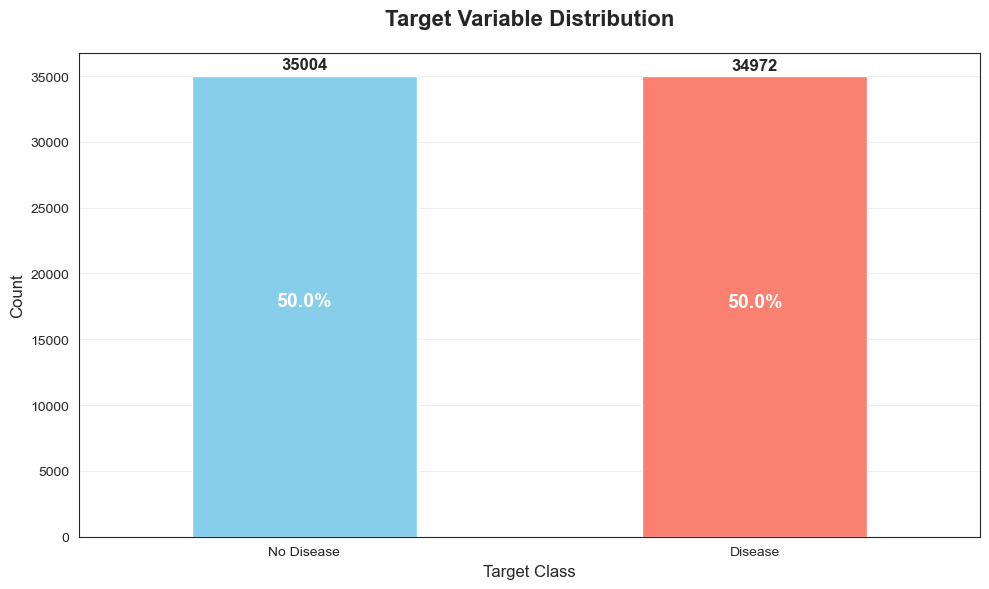

WindowsPath('p:/projects/heart_disease_prediction/reports/visualizations/univariate_analysis/numerical_analysis/01_target_distribution.png')

In [115]:
def plot_target_distribution(df, save_path=None):
  
    # Set up paths
    if save_path is None:
        # Navigate to project root
        current_path = Path.cwd()
        while current_path.name not in ['heart_disease_prediction'] and current_path != current_path.parent:
            current_path = current_path.parent
        
        # Define directories
        PROJECT_ROOT = current_path
        PLOT_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'univariate_analysis' / 'numerical_analysis'
        
        # Create directory only if it doesn't exist
        PLOT_DIR.mkdir(parents=True, exist_ok=True)
        
        save_path = PLOT_DIR / '01_target_distribution.png'
    else:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
    
    # Create plot
    plt.figure(figsize=(10, 6))
    
    # Bar plot
    df['target'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
    
    # Add count labels on bars
    for i, v in enumerate(df['target'].value_counts()):
        plt.text(i, v + 500, str(v), ha='center', fontweight='bold', fontsize=12)
    
    # Formatting
    plt.title('Target Variable Distribution', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Target Class', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)
    
    # Add percentage labels
    total = len(df)
    for i, v in enumerate(df['target'].value_counts()):
        pct = (v / total * 100)
        plt.text(i, v/2, f'{pct:.1f}%', ha='center', fontweight='bold', 
                 fontsize=14, color='white')
    
    plt.tight_layout()
    
    # Save (always overwrites existing file)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ Plot saved to: {save_path}")
    
    # Display
    plt.show()
    plt.close()
    
    return save_path

plot_target_distribution(df)

* The target variable is balanced (50% No Disease, 50% Disease), so no balancing technique is needed.

### Numerical Analysis

In [116]:
# ==============================================================
# setup paths
# ==============================================================

current_path = Path.cwd()
while current_path.name not in ['heart_disease_prediction'] and current_path != current_path.parent:
    current_path = current_path.parent

PROJECT_ROOT = current_path
UNIVARIATE_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'univariate_analysis' / 'numerical_analysis'
BIVARIATE_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'bivariate_analysis' / 'numerical_analysis'

UNIVARIATE_DIR.mkdir(parents=True, exist_ok=True)
BIVARIATE_DIR.mkdir(parents=True, exist_ok=True)

 ✓ Saved (hidden): p:\projects\heart_disease_prediction\reports\visualizations\univariate_analysis\numerical_analysis\02_age_analysis_univariate.png
✓ Bivariate plot saved to: p:\projects\heart_disease_prediction\reports\visualizations\bivariate_analysis\numerical_analysis\02_age_analysis_bivariate.png


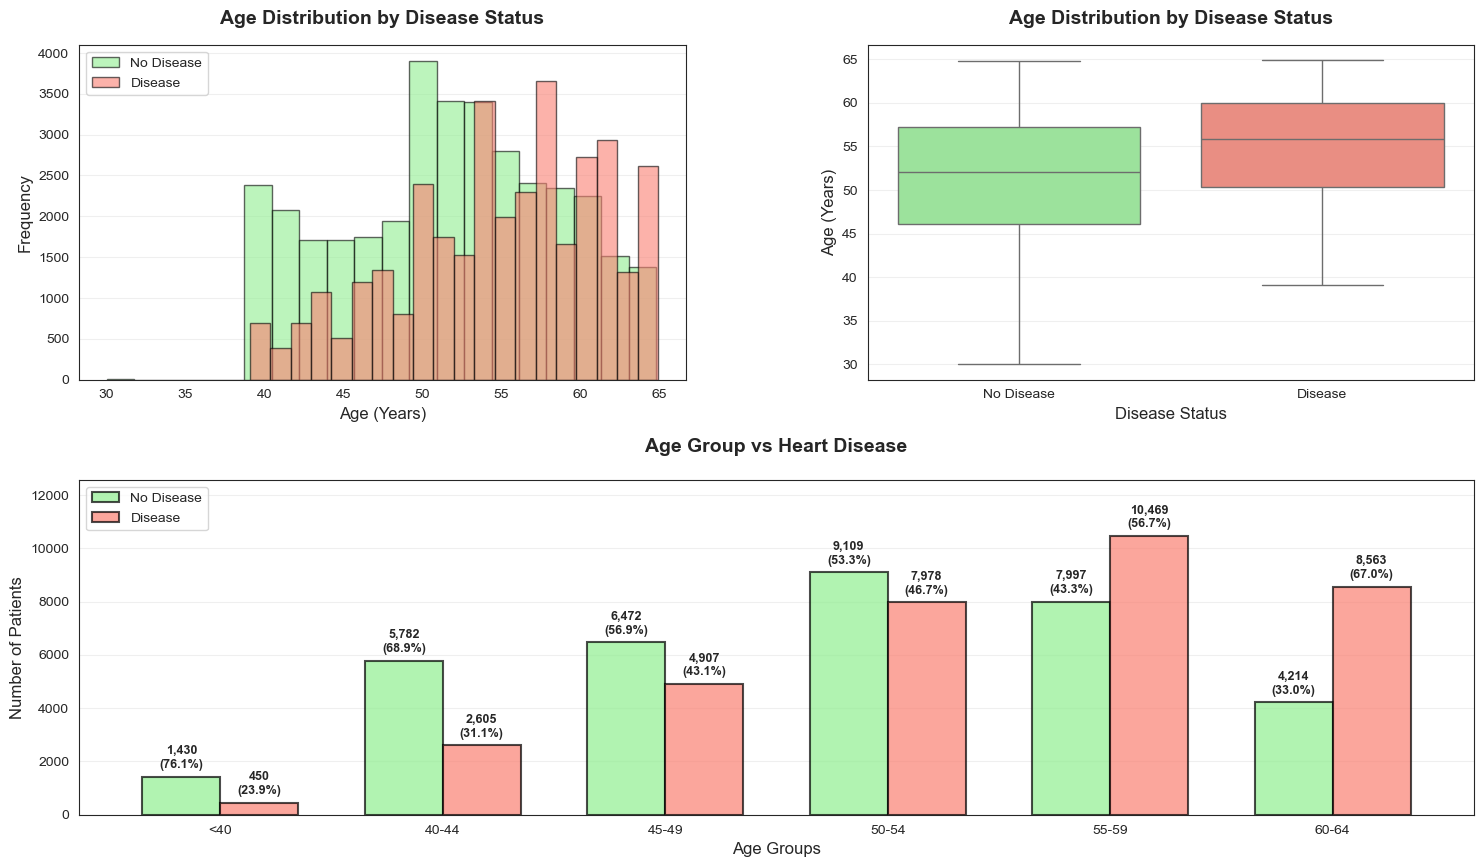

In [117]:
# ==============================================================
# CREATE AGE GROUPS
# ==============================================================

age_bins = [0, 40, 45, 50, 55, 60, 65, 70, 120]
age_labels = ['<40', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70+']

df['Age_Group'] = pd.cut(df['Age_Years'], bins=age_bins, labels=age_labels, right=False)
df['Age_Group'] = pd.Categorical(df['Age_Group'], categories=age_labels, ordered=True)

# Get ONLY non-empty groups
age_group_counts = df['Age_Group'].value_counts().sort_index()
non_empty_groups = age_group_counts[age_group_counts > 0].index.tolist()

# ==============================================================
# UNIVARIATE ANALYSIS - 2x1 Layout
# ==============================================================

fig_univariate = plt.figure(figsize=(18, 10))
gs = fig_univariate.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

ax1 = fig_univariate.add_subplot(gs[0, 0])
ax2 = fig_univariate.add_subplot(gs[0, 1])
ax3 = fig_univariate.add_subplot(gs[1, :])

# Plot 1: Histogram
ax1.hist(df['Age_Years'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_title('Age Distribution (Histogram)', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Age (Years)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Boxplot
ax2.boxplot(df['Age_Years'], vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', alpha=0.7),
            medianprops=dict(color='red', linewidth=2))
ax2.set_title('Age Distribution (Boxplot)', fontsize=14, fontweight='bold', pad=15)
ax2.set_ylabel('Age (Years)', fontsize=12)
ax2.set_xticklabels([''])
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Age Group Bar Chart (ONLY non-empty bins)
overall_counts = age_group_counts[age_group_counts > 0]  # Filter out empty bins
total_patients = len(df)

bars = ax3.bar(range(len(overall_counts)), overall_counts.values,
               color='lightblue', alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.set_title('Age Group Distribution', fontsize=14, fontweight='bold', pad=20)
ax3.set_xlabel('Age Groups', fontsize=12)
ax3.set_ylabel('Number of Patients', fontsize=12)
ax3.set_xticks(range(len(overall_counts)))
ax3.set_xticklabels(overall_counts.index, rotation=0)
ax3.grid(axis='y', alpha=0.3)

# Set y-axis limit
max_height = overall_counts.max()
ax3.set_ylim(0, max_height * 1.2)

# Add labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    pct = height / total_patients * 100
    ax3.text(bar.get_x() + bar.get_width()/2, height + max_height*0.02,
             f'{int(height):,}\n({pct:.1f}%)',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

univariate_path = UNIVARIATE_DIR / '02_age_analysis_univariate.png'
plt.savefig(univariate_path, dpi=300, bbox_inches='tight')
print(f" ✓ Saved (hidden): {univariate_path}")
plt.close()

# ==============================================================
# BIVARIATE ANALYSIS - 2x1 Layout
# ==============================================================

fig_bivariate = plt.figure(figsize=(18, 10))
gs = fig_bivariate.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

ax1 = fig_bivariate.add_subplot(gs[0, 0])
ax2 = fig_bivariate.add_subplot(gs[0, 1])
ax3 = fig_bivariate.add_subplot(gs[1, :])

# Determine target values
no_disease_val = 'No Disease' if 'No Disease' in df['target'].values else 0
disease_val = 'Disease' if 'Disease' in df['target'].values else 1

# Plot 1: Histogram by Target
for target_val, color, label in [(no_disease_val, 'lightgreen', 'No Disease'),
                                  (disease_val, 'salmon', 'Disease')]:
    data = df[df['target'] == target_val]['Age_Years']
    ax1.hist(data, bins=20, alpha=0.6, label=label, color=color, edgecolor='black')

ax1.set_title('Age Distribution by Disease Status', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Age (Years)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Boxplot by Target
df_boxplot = df[['Age_Years', 'target']].copy()
sns.boxplot(x='target', y='Age_Years', data=df_boxplot, ax=ax2,
            palette={no_disease_val: 'lightgreen', disease_val: 'salmon'})
ax2.set_title('Age Distribution by Disease Status', fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('Disease Status', fontsize=12)
ax2.set_ylabel('Age (Years)', fontsize=12)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Age Group Bar Chart by Target (ONLY non-empty bins)
target_pivot = (df.groupby(['Age_Group', 'target'])
                .size()
                .unstack(fill_value=0))

# Keep only non-empty age groups
target_pivot = target_pivot.loc[non_empty_groups]

bar_width = 0.35
x = np.arange(len(target_pivot))

# Determine column names
no_disease_col = no_disease_val
disease_col = disease_val

if no_disease_col in target_pivot.columns:
    ax3.bar(x - bar_width/2, target_pivot[no_disease_col],
            bar_width, label='No Disease', color='lightgreen',
            alpha=0.7, edgecolor='black', linewidth=1.5)

if disease_col in target_pivot.columns:
    ax3.bar(x + bar_width/2, target_pivot[disease_col],
            bar_width, label='Disease', color='salmon',
            alpha=0.7, edgecolor='black', linewidth=1.5)

ax3.set_title('Age Group vs Heart Disease', fontsize=14, fontweight='bold', pad=20)
ax3.set_xlabel('Age Groups', fontsize=12)
ax3.set_ylabel('Number of Patients', fontsize=12)
ax3.set_xticks(x)
ax3.set_xticklabels(target_pivot.index, rotation=0)
ax3.grid(axis='y', alpha=0.3)
ax3.legend(loc='upper left')

# Set y-axis limit
max_val = target_pivot.values.max()
ax3.set_ylim(0, max_val * 1.2)

# Add labels
for idx, age_grp in enumerate(target_pivot.index):
    grp_total = target_pivot.loc[age_grp].sum()
    if grp_total == 0:
        continue
    for offset, col in [(-bar_width/2, no_disease_col), (bar_width/2, disease_col)]:
        if col in target_pivot.columns:
            val = target_pivot.at[age_grp, col]
            if val > 0:
                ax3.text(idx + offset, val + max_val*0.02,
                        f'{int(val):,}\n({val/grp_total*100:.1f}%)',
                        ha='center', va='bottom', fontsize=9, fontweight='bold')

bivariate_path = BIVARIATE_DIR / '02_age_analysis_bivariate.png'
plt.savefig(bivariate_path, dpi=300, bbox_inches='tight')
print(f"✓ Bivariate plot saved to: {bivariate_path}")
plt.show()
plt.close()

df= df.drop(columns=['Age_Group'])

* Older patients have a much higher rate of heart disease, with risk increasing clearly with age. Most patients younger than 40 years are healthy, and there are very few disease cases in this group. Because the <40 group is small and has few positive cases, the model will struggle to accurately identify heart disease for these younger patients.

✓ Saved (hidden): p:\projects\heart_disease_prediction\reports\visualizations\univariate_analysis\numerical_analysis\03_bp_analysis_univariate.png
✓ Bivariate plot saved to: p:\projects\heart_disease_prediction\reports\visualizations\bivariate_analysis\numerical_analysis\03_bp_analysis_bivariate.png


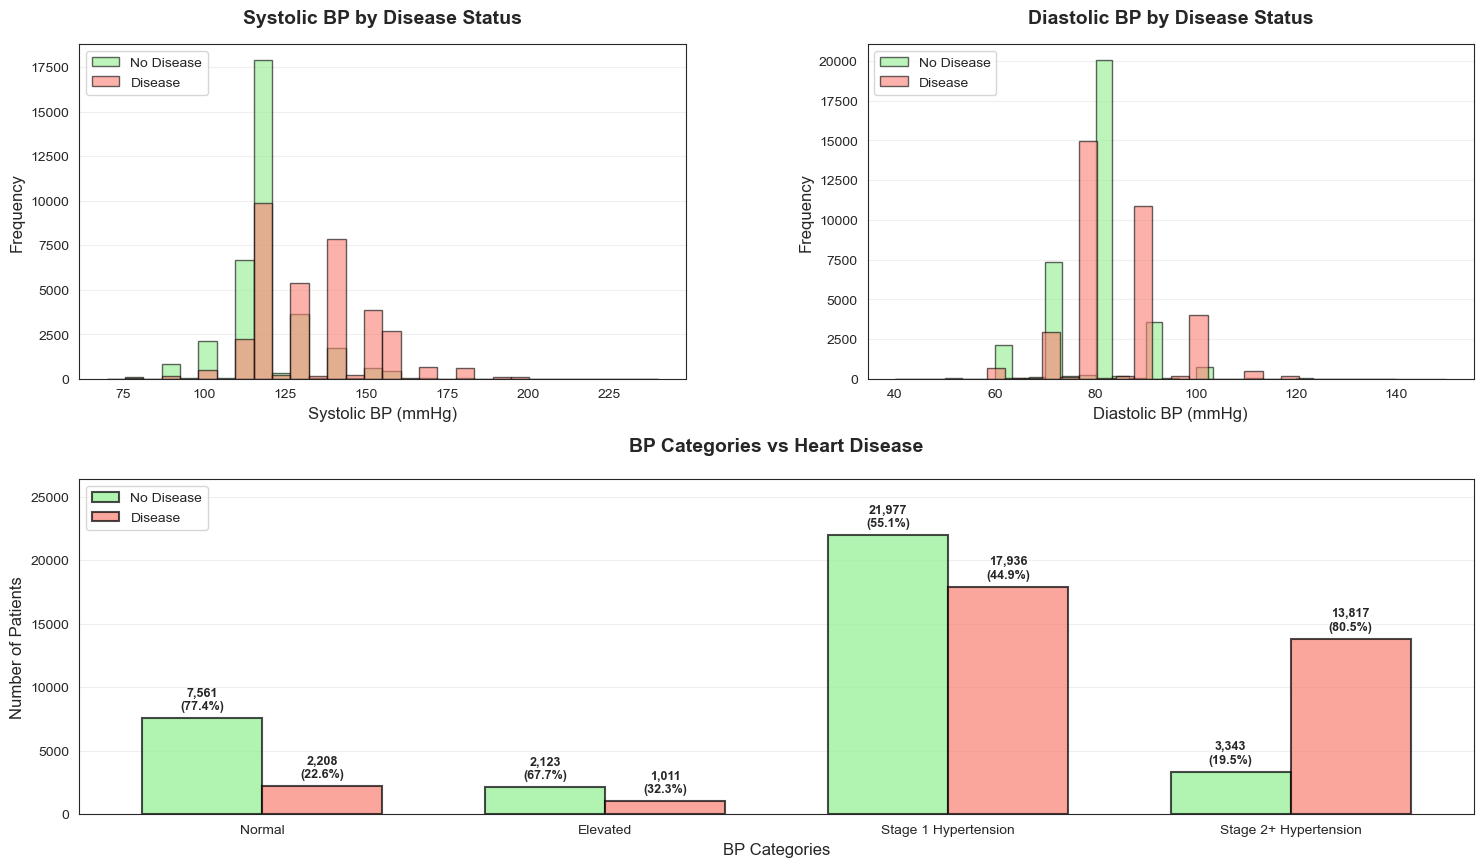

In [118]:
# ==============================================================
# CREATE BP GROUPS WITH CLINICAL MERGING
# ==============================================================

def get_bp_category_merged(systolic, diastolic):
    """Categorize BP with clinical merging of rare categories"""
    if systolic < 120 and diastolic < 80:
        return 'Normal'
    elif 120 <= systolic < 130 and diastolic < 80:
        return 'Elevated'
    elif (130 <= systolic < 140) or (80 <= diastolic < 90):
        return 'Stage 1 Hypertension'
    else:
        return 'Stage 2+ Hypertension'

df['BP_Group'] = df.apply(lambda row: get_bp_category_merged(
    row['Systolic_BP'], row['Diastolic_BP']), axis=1)

bp_category_order = ['Normal', 'Elevated', 'Stage 1 Hypertension', 'Stage 2+ Hypertension']
df['BP_Group'] = pd.Categorical(df['BP_Group'], categories=bp_category_order, ordered=True)

# Get ONLY non-empty groups
bp_counts = df['BP_Group'].value_counts().sort_index()
non_empty_bp_groups = bp_counts[bp_counts > 0].index.tolist()

colors = ['lightgreen', 'gold', 'orange', 'lightcoral']
color_dict = dict(zip(bp_category_order, colors))

# ==============================================================
# UNIVARIATE ANALYSIS - 2x1 Layout
# ==============================================================

fig_univariate = plt.figure(figsize=(18, 10))
gs = fig_univariate.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

ax1 = fig_univariate.add_subplot(gs[0, 0])
ax2 = fig_univariate.add_subplot(gs[0, 1])
ax3 = fig_univariate.add_subplot(gs[1, :])

# Plot 1: Systolic BP Histogram
ax1.hist(df['Systolic_BP'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_title('Systolic BP Distribution', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Systolic BP (mmHg)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Systolic BP Boxplot
ax2.boxplot(df['Systolic_BP'], vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', alpha=0.7),
            medianprops=dict(color='red', linewidth=2))
ax2.set_title('Systolic BP Distribution', fontsize=14, fontweight='bold', pad=15)
ax2.set_ylabel('Systolic BP (mmHg)', fontsize=12)
ax2.set_xticklabels([''])
ax2.grid(axis='y', alpha=0.3)

# Plot 3: BP Group Bar Chart (bottom, full width, ONLY non-empty)
overall_counts = bp_counts[bp_counts > 0]
total_patients = len(df)

bars = ax3.bar(range(len(overall_counts)), overall_counts.values,
               color=[color_dict.get(g, 'gray') for g in overall_counts.index],
               alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.set_title('Blood Pressure Categories', fontsize=14, fontweight='bold', pad=20)
ax3.set_xlabel('BP Categories', fontsize=12)
ax3.set_ylabel('Number of Patients', fontsize=12)
ax3.set_xticks(range(len(overall_counts)))
ax3.set_xticklabels(overall_counts.index, rotation=0)
ax3.grid(axis='y', alpha=0.3)

max_height = overall_counts.max()
ax3.set_ylim(0, max_height * 1.2)

for i, bar in enumerate(bars):
    height = bar.get_height()
    pct = height / total_patients * 100
    ax3.text(bar.get_x() + bar.get_width()/2, height + max_height*0.02,
             f'{int(height):,}\n({pct:.1f}%)',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

univariate_path = UNIVARIATE_DIR / '03_bp_analysis_univariate.png'
plt.savefig(univariate_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved (hidden): {univariate_path}")
plt.close()

# ==============================================================
# BIVARIATE ANALYSIS - 2x1 Layout (UPDATED)
# ==============================================================

fig_bivariate = plt.figure(figsize=(18, 10))
gs = fig_bivariate.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

ax1 = fig_bivariate.add_subplot(gs[0, 0])
ax2 = fig_bivariate.add_subplot(gs[0, 1])
ax3 = fig_bivariate.add_subplot(gs[1, :])

no_disease_val = 'No Disease' if 'No Disease' in df['target'].values else 0
disease_val = 'Disease' if 'Disease' in df['target'].values else 1

# Plot 1: Systolic BP Histogram by Target
for target_val, color, label in [(no_disease_val, 'lightgreen', 'No Disease'),
                                  (disease_val, 'salmon', 'Disease')]:
    data = df[df['target'] == target_val]['Systolic_BP']
    ax1.hist(data, bins=30, alpha=0.6, label=label, color=color, edgecolor='black')

ax1.set_title('Systolic BP by Disease Status', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Systolic BP (mmHg)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Diastolic BP Histogram by Target (UPDATED FROM BOXPLOT)
for target_val, color, label in [(no_disease_val, 'lightgreen', 'No Disease'),
                                  (disease_val, 'salmon', 'Disease')]:
    data = df[df['target'] == target_val]['Diastolic_BP']
    ax2.hist(data, bins=30, alpha=0.6, label=label, color=color, edgecolor='black')

ax2.set_title('Diastolic BP by Disease Status', fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('Diastolic BP (mmHg)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(axis='y', alpha=0.3)

# Plot 3: BP Group Bar Chart by Target (bottom, full width, ONLY non-empty)
bp_target = (df.groupby(['BP_Group', 'target'])
             .size()
             .unstack(fill_value=0))
bp_target = bp_target.loc[non_empty_bp_groups]

bar_width = 0.35
x = np.arange(len(bp_target))

no_disease_col = no_disease_val
disease_col = disease_val

if no_disease_col in bp_target.columns:
    ax3.bar(x - bar_width/2, bp_target[no_disease_col],
            bar_width, label='No Disease', color='lightgreen',
            alpha=0.7, edgecolor='black', linewidth=1.5)

if disease_col in bp_target.columns:
    ax3.bar(x + bar_width/2, bp_target[disease_col],
            bar_width, label='Disease', color='salmon',
            alpha=0.7, edgecolor='black', linewidth=1.5)

ax3.set_title('BP Categories vs Heart Disease', fontsize=14, fontweight='bold', pad=20)
ax3.set_xlabel('BP Categories', fontsize=12)
ax3.set_ylabel('Number of Patients', fontsize=12)
ax3.set_xticks(x)
ax3.set_xticklabels(bp_target.index, rotation=0)
ax3.grid(axis='y', alpha=0.3)
ax3.legend(loc='upper left')

max_val = bp_target.values.max()
ax3.set_ylim(0, max_val * 1.2)

for idx, bp_grp in enumerate(bp_target.index):
    grp_total = bp_target.loc[bp_grp].sum()
    if grp_total == 0:
        continue
    for offset, col in [(-bar_width/2, no_disease_col), (bar_width/2, disease_col)]:
        if col in bp_target.columns:
            val = bp_target.at[bp_grp, col]
            if val > 0:
                ax3.text(idx + offset, val + max_val*0.02,
                        f'{int(val):,}\n({val/grp_total*100:.1f}%)',
                        ha='center', va='bottom', fontsize=9, fontweight='bold')

bivariate_path = BIVARIATE_DIR / '03_bp_analysis_bivariate.png'
plt.savefig(bivariate_path, dpi=300, bbox_inches='tight')
print(f"✓ Bivariate plot saved to: {bivariate_path}")
plt.show()
plt.close()

df= df.drop(columns=['BP_Group'])


* Heart disease is much more common in patients with higher systolic blood pressure, especially at Stage 2+ Hypertension. Patients with normal or elevated BP rarely have heart disease. However, because the normal and elevated BP groups are much smaller, the model may struggle or even fail to classify these patients correctly

✓ Saved (hidden): p:\projects\heart_disease_prediction\reports\visualizations\univariate_analysis\numerical_analysis\04_bmi_analysis_univariate.png
✓ Bivariate plot saved to: p:\projects\heart_disease_prediction\reports\visualizations\bivariate_analysis\numerical_analysis\04_bmi_analysis_bivariate.png


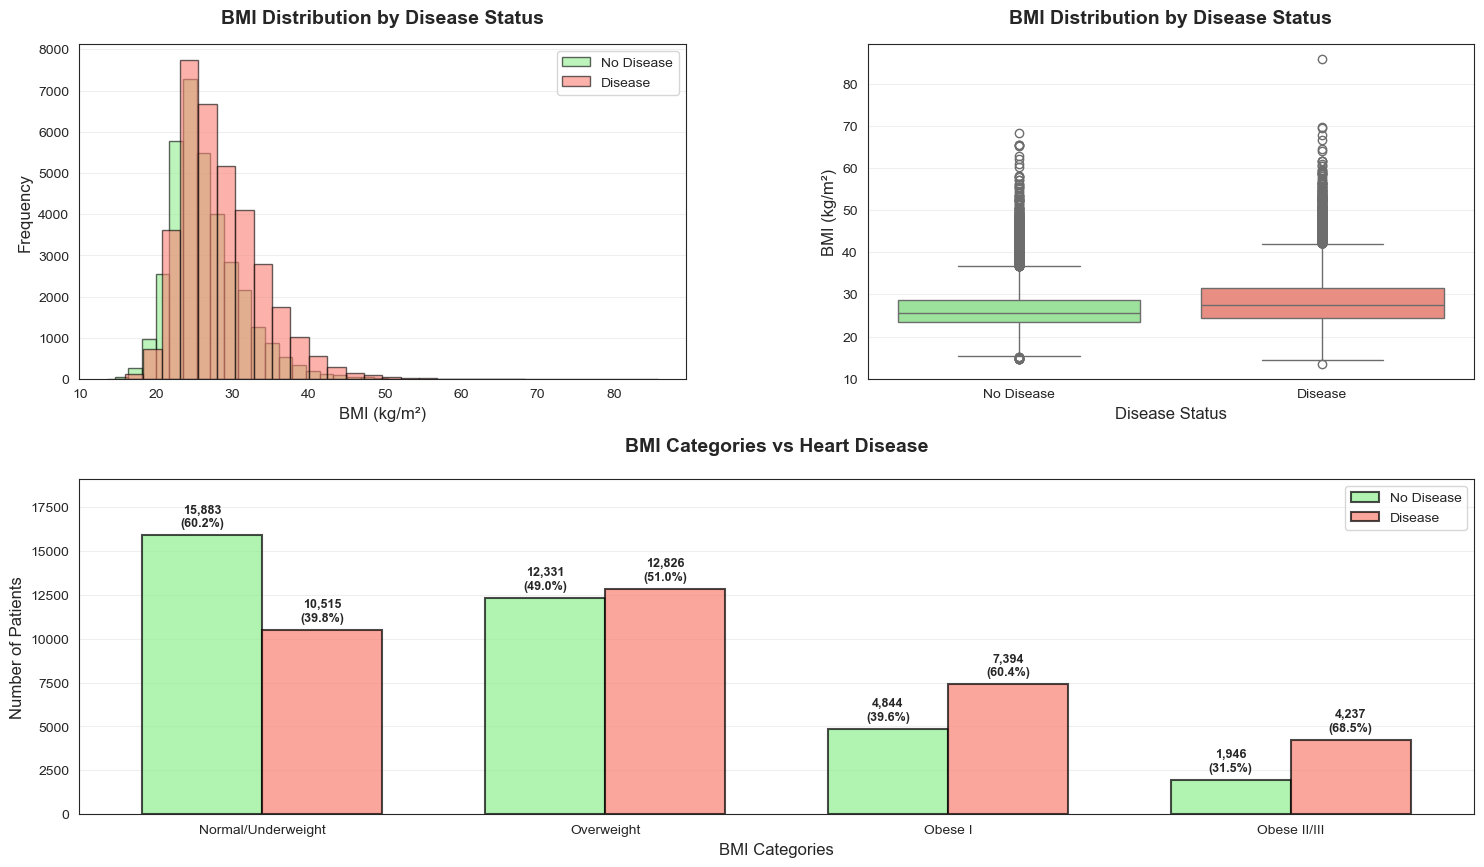

In [119]:
# ==============================================================
# BMI CALCULATION AND CATEGORIZATION
# ==============================================================
# Calculate BMI (kg/m²)
if 'BMI' not in df.columns:
    df['BMI'] = df['Weight'] / ((df['Height'] / 100) ** 2)

# Handle NaN values
bmi_nan = df['BMI'].isna().sum()
if bmi_nan > 0:
    bmi_median = df['BMI'].median()
    df['BMI'].fillna(bmi_median, inplace=True)
    print(f"✓ Imputed {bmi_nan} NaN BMI values with median {bmi_median:.2f}")

# Define BMI categories
bmi_bins = [0, 25, 30, 35, 100]
bmi_labels = ['Normal/Underweight', 'Overweight', 'Obese I', 'Obese II/III']

df['BMI_Group'] = pd.cut(df['BMI'], bins=bmi_bins, labels=bmi_labels, right=False)
df['BMI_Group'] = pd.Categorical(df['BMI_Group'], categories=bmi_labels, ordered=True)

# Get ONLY non-empty groups
bmi_counts = df['BMI_Group'].value_counts().sort_index()
non_empty_groups = bmi_counts[bmi_counts > 0].index.tolist()

# Drop Weight and Height
if 'Weight' in df.columns and 'Height' in df.columns:
    df = df.drop(columns=['Weight', 'Height'])

colors = ['lightgreen', 'gold', 'orange', 'lightcoral']
color_dict = dict(zip(bmi_labels, colors))

# ==============================================================
# UNIVARIATE ANALYSIS - 2x1 Layout
# ==============================================================

fig_univariate = plt.figure(figsize=(18, 10))
gs = fig_univariate.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

ax1 = fig_univariate.add_subplot(gs[0, 0])
ax2 = fig_univariate.add_subplot(gs[0, 1])
ax3 = fig_univariate.add_subplot(gs[1, :])

# Plot 1: BMI Histogram
ax1.hist(df['BMI'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_title('BMI Distribution', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('BMI (kg/m²)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: BMI Boxplot
ax2.boxplot(df['BMI'], vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', alpha=0.7),
            medianprops=dict(color='red', linewidth=2))
ax2.set_title('BMI Distribution', fontsize=14, fontweight='bold', pad=15)
ax2.set_ylabel('BMI (kg/m²)', fontsize=12)
ax2.set_xticklabels([''])
ax2.grid(axis='y', alpha=0.3)

# Plot 3: BMI Group Bar Chart (bottom, full width, ONLY non-empty)
overall_counts = bmi_counts[bmi_counts > 0]
total_patients = len(df)

bars = ax3.bar(range(len(overall_counts)), overall_counts.values,
               color=[color_dict.get(g, 'gray') for g in overall_counts.index],
               alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.set_title('BMI Categories', fontsize=14, fontweight='bold', pad=20)
ax3.set_xlabel('BMI Categories', fontsize=12)
ax3.set_ylabel('Number of Patients', fontsize=12)
ax3.set_xticks(range(len(overall_counts)))
ax3.set_xticklabels(overall_counts.index, rotation=0)
ax3.grid(axis='y', alpha=0.3)

max_height = overall_counts.max()
ax3.set_ylim(0, max_height * 1.2)

for i, bar in enumerate(bars):
    height = bar.get_height()
    pct = height / total_patients * 100
    ax3.text(bar.get_x() + bar.get_width()/2, height + max_height*0.02,
             f'{int(height):,}\n({pct:.1f}%)',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

univariate_path = UNIVARIATE_DIR / '04_bmi_analysis_univariate.png'
plt.savefig(univariate_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved (hidden): {univariate_path}")
plt.close()

# ==============================================================
# BIVARIATE ANALYSIS - 2x1 Layout
# ==============================================================

fig_bivariate = plt.figure(figsize=(18, 10))
gs = fig_bivariate.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

ax1 = fig_bivariate.add_subplot(gs[0, 0])
ax2 = fig_bivariate.add_subplot(gs[0, 1])
ax3 = fig_bivariate.add_subplot(gs[1, :])

no_disease_val = 'No Disease' if 'No Disease' in df['target'].values else 0
disease_val = 'Disease' if 'Disease' in df['target'].values else 1

# Plot 1: BMI Histogram by Target
for target_val, color, label in [(no_disease_val, 'lightgreen', 'No Disease'),
                                  (disease_val, 'salmon', 'Disease')]:
    data = df[df['target'] == target_val]['BMI']
    ax1.hist(data, bins=30, alpha=0.6, label=label, color=color, edgecolor='black')

ax1.set_title('BMI Distribution by Disease Status', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('BMI (kg/m²)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.legend(loc='upper right')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: BMI Boxplot by Target
df_boxplot = df[['BMI', 'target']].copy()
sns.boxplot(x='target', y='BMI', data=df_boxplot, ax=ax2,
            palette={no_disease_val: 'lightgreen', disease_val: 'salmon'})
ax2.set_title('BMI Distribution by Disease Status', fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('Disease Status', fontsize=12)
ax2.set_ylabel('BMI (kg/m²)', fontsize=12)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: BMI Group Bar Chart by Target (bottom, full width, ONLY non-empty)
bmi_target = (df.groupby(['BMI_Group', 'target'])
              .size()
              .unstack(fill_value=0))
bmi_target = bmi_target.loc[non_empty_groups]

bar_width = 0.35
x = np.arange(len(bmi_target))

no_disease_col = no_disease_val
disease_col = disease_val

if no_disease_col in bmi_target.columns:
    ax3.bar(x - bar_width/2, bmi_target[no_disease_col],
            bar_width, label='No Disease', color='lightgreen',
            alpha=0.7, edgecolor='black', linewidth=1.5)

if disease_col in bmi_target.columns:
    ax3.bar(x + bar_width/2, bmi_target[disease_col],
            bar_width, label='Disease', color='salmon',
            alpha=0.7, edgecolor='black', linewidth=1.5)

ax3.set_title('BMI Categories vs Heart Disease', fontsize=14, fontweight='bold', pad=20)
ax3.set_xlabel('BMI Categories', fontsize=12)
ax3.set_ylabel('Number of Patients', fontsize=12)
ax3.set_xticks(x)
ax3.set_xticklabels(bmi_target.index, rotation=0)
ax3.grid(axis='y', alpha=0.3)
ax3.legend(loc='upper right')

max_val = bmi_target.values.max()
ax3.set_ylim(0, max_val * 1.2)

for idx, bmi_grp in enumerate(bmi_target.index):
    grp_total = bmi_target.loc[bmi_grp].sum()
    if grp_total == 0:
        continue
    for offset, col in [(-bar_width/2, no_disease_col), (bar_width/2, disease_col)]:
        if col in bmi_target.columns:
            val = bmi_target.at[bmi_grp, col]
            if val > 0:
                ax3.text(idx + offset, val + max_val*0.02,
                        f'{int(val):,}\n({val/grp_total*100:.1f}%)',
                        ha='center', va='bottom', fontsize=9, fontweight='bold')

bivariate_path = BIVARIATE_DIR / '04_bmi_analysis_bivariate.png'
plt.savefig(bivariate_path, dpi=300, bbox_inches='tight')
print(f"✓ Bivariate plot saved to: {bivariate_path}")
plt.show()
plt.close()

df= df.drop(columns=['BMI_Group'])

* As BMI increases, the chance of heart disease rises, with Obese II/III categories showing the highest disease rates. Most normal or underweight patients are healthy, and heart disease is least common in these groups. However, because the Obese II/III group is much smaller, the model may struggle and often misclassify them due to the limited data for these extremes.

✓ Saved (hidden): p:\projects\heart_disease_prediction\reports\visualizations\univariate_analysis\numerical_analysis\05_pairplot_all_features_univariate.png
✓ Saved: p:\projects\heart_disease_prediction\reports\visualizations\bivariate_analysis\numerical_analysis\05_pairplot_all_features_bivariate.png


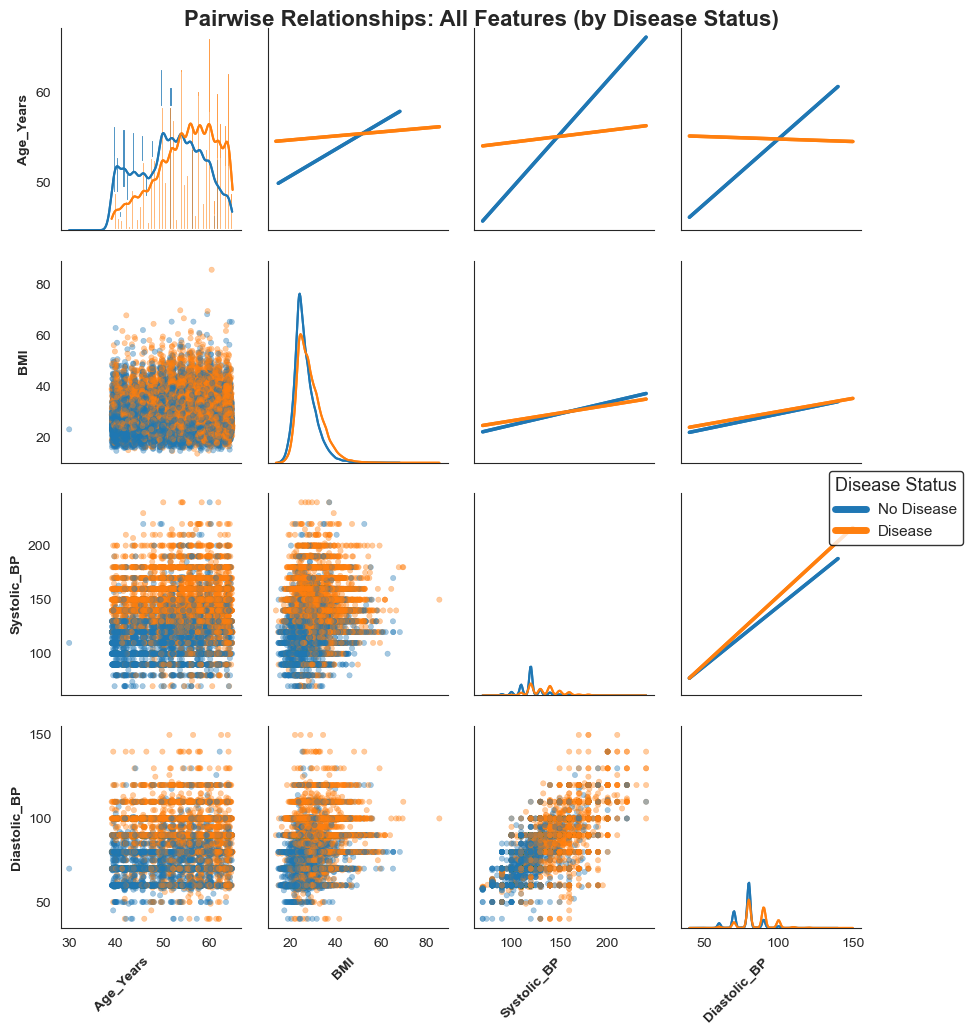

In [120]:
# ==============================================================
# PAIRWISE RELATIONSHIP ANALYSIS (PAIRPLOT)
# ==============================================================
raw_features = ['Age_Years', 'BMI', 'Systolic_BP', 'Diastolic_BP']

# ==============================================================
# Target palette
# ==============================================================

TARGET_PALETTE_LIST = ['#1f77b4', '#ff7f0e']
PAIRGRID_PALETTE = dict(zip(['No Disease', 'Disease'], TARGET_PALETTE_LIST))

# ==============================================================
# Prepare DataFrame
# ==============================================================

df_plot = df.copy()
if 'target_name' not in df_plot.columns:
    if df_plot['target'].dtype == 'object':
        df_plot['target_name'] = df_plot['target']
    else:
        df_plot['target_name'] = df_plot['target'].map({0: 'No Disease', 1: 'Disease'})

# Styling
sns.set_style("white")

# ==============================================================
# UNIVARIATE PAIRPLOT: ALL FEATURES (SAVE BUT DON'T DISPLAY)
# ==============================================================
g_uni = sns.PairGrid(
    df_plot,
    vars=raw_features,
    diag_sharey=False,
    height=2.5,
    aspect=1.0
)

# Upper: only regplot (no scatter)
g_uni.map_upper(sns.regplot, scatter=False, color='gray', line_kws={'linewidth': 2})

# Lower: scatter without color
g_uni.map_lower(sns.scatterplot, alpha=0.3, s=15, edgecolor=None, color='gray')

# Diagonal: histogram
g_uni.map_diag(sns.histplot, color='steelblue', alpha=0.6, kde=True)

# Remove grid
for ax_row in g_uni.axes:
    for ax in ax_row:
        ax.grid(False)
        ax.locator_params(axis='both', nbins=4)

# Set labels
for i, var in enumerate(raw_features):
    g_uni.axes[i, 0].set_ylabel(var, fontsize=10, fontweight='bold')
    g_uni.axes[-1, i].set_xlabel(var, fontsize=10, fontweight='bold', rotation=45, ha='right')

g_uni.fig.suptitle('Pairwise Relationships: All Features', fontsize=16, y=0.998, weight='bold')

plt.subplots_adjust(hspace=0.15, wspace=0.15, top=0.98, bottom=0.08)

# Save (no display)
univariate_path = UNIVARIATE_DIR / '05_pairplot_all_features_univariate.png'
plt.savefig(univariate_path, bbox_inches='tight', dpi=200, facecolor='white')
print(f"✓ Saved (hidden): {univariate_path}")
plt.close()

# ==============================================================
# BIVARIATE PAIRPLOT: ALL FEATURES (SAVE AND DISPLAY)
# ==============================================================
g_bi = sns.PairGrid(
    df_plot,
    vars=raw_features,
    hue='target_name',
    palette=PAIRGRID_PALETTE,
    diag_sharey=False,
    height=2.5,
    aspect=1.0
)

# Upper: ONLY regplot by target (no scatter, straight linear line)
def regplot_only(x, y, **kwargs):
    for name, color in PAIRGRID_PALETTE.items():
        subset = df_plot[df_plot['target_name'] == name]
        if subset[x.name].notna().sum() > 2 and subset[y.name].notna().sum() > 2:
            sns.regplot(
                x=subset[x.name], y=subset[y.name], 
                scatter=False,  # No scatter points
                ci=None,        # No confidence interval
                order=1,        # Linear only (no polynomial smoothing)
                line_kws={'color': color, 'linewidth': 2.5},
                ax=plt.gca()
            )

g_bi.map_upper(regplot_only)

# Lower: scatter by target
g_bi.map_lower(sns.scatterplot, alpha=0.4, s=15, edgecolor=None)

# Diagonal: histogram by target
def hist_diag(x, **kwargs):
    ax = plt.gca()
    for name, color in PAIRGRID_PALETTE.items():
        subset = df_plot[df_plot['target_name'] == name]
        if subset[x.name].notna().sum() > 1:
            sns.histplot(subset[x.name], color=color, alpha=0.6, kde=True, 
                        ax=ax, stat='density', linewidth=1.5)
    if ax.get_legend():
        ax.get_legend().remove()

g_bi.map_diag(hist_diag)

# Remove grid
for ax_row in g_bi.axes:
    for ax in ax_row:
        ax.grid(False)
        ax.locator_params(axis='both', nbins=4)

# Set labels
for i, var in enumerate(raw_features):
    g_bi.axes[i, 0].set_ylabel(var, fontsize=10, fontweight='bold')
    g_bi.axes[-1, i].set_xlabel(var, fontsize=10, fontweight='bold', rotation=45, ha='right')

g_bi.fig.suptitle('Pairwise Relationships: All Features (by Disease Status)', 
                   fontsize=16, y=0.998, weight='bold')

# Legend
handles = [plt.Line2D([0], [0], color=color, lw=5, label=name) 
           for name, color in PAIRGRID_PALETTE.items()]
g_bi.fig.legend(
    handles, list(PAIRGRID_PALETTE.keys()), 
    title='Disease Status', 
    title_fontsize=13, fontsize=11,
    loc='center right',
    bbox_to_anchor=(0.99, 0.5),
    frameon=True, edgecolor='black'
)

plt.subplots_adjust(hspace=0.15, wspace=0.15, top=0.98, bottom=0.08, left=0.08, right=0.88)

# Save and display
bivariate_path = BIVARIATE_DIR / '05_pairplot_all_features_bivariate.png'
plt.savefig(bivariate_path, bbox_inches='tight', dpi=200, facecolor='white')
print(f"✓ Saved: {bivariate_path}")
plt.show()
plt.close()

# Cleanup
del df_plot

✓  heatmap saved to: p:\projects\heart_disease_prediction\reports\visualizations\multivariate_analysis\01_correlation_heatmap.png


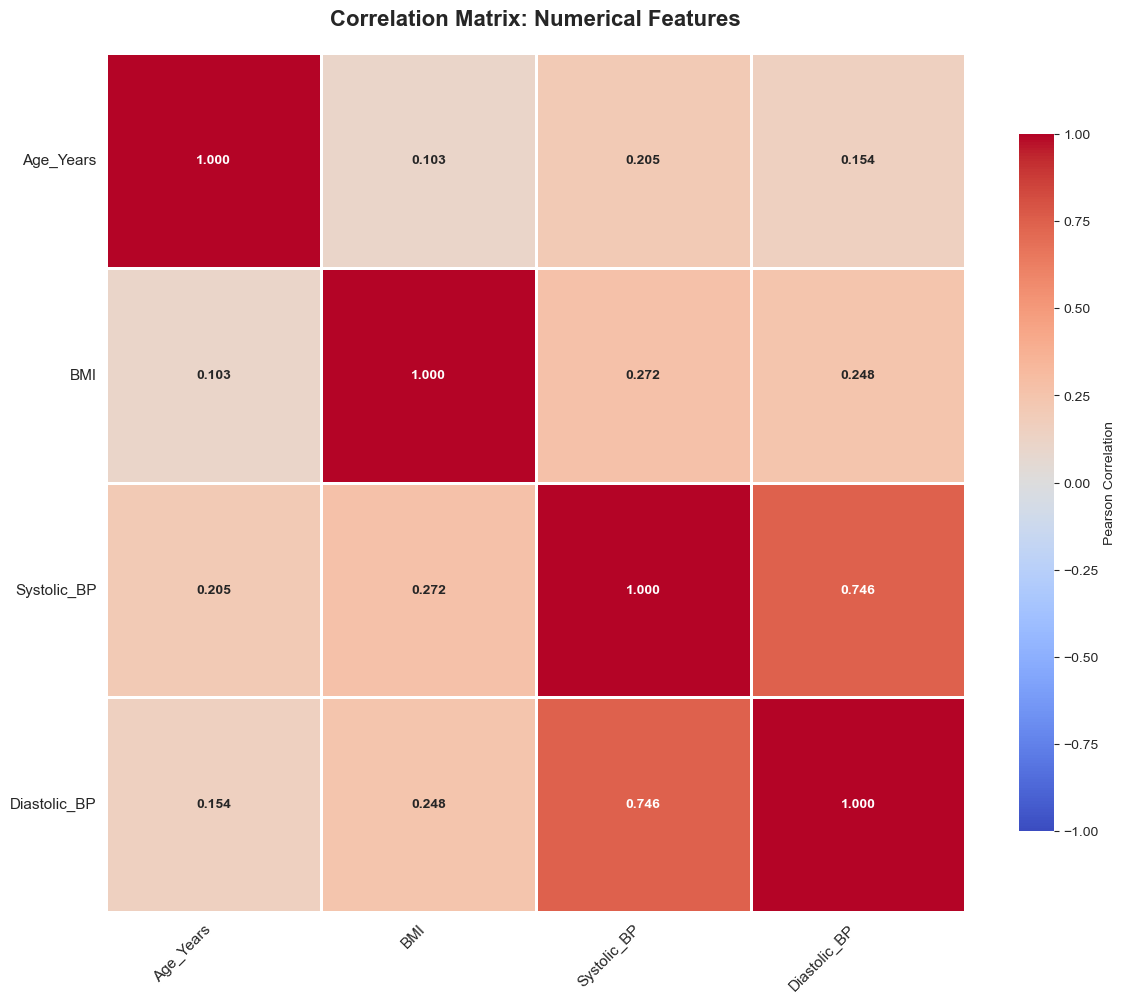

In [121]:
def create_numerical_correlation_heatmap(df, save_path=None):
    
    # Numerical features to analyze
    numerical_cols = ['Age_Years','BMI','Systolic_BP','Diastolic_BP']

    # Set default save path
    if save_path is None:
        # Navigate to project root
        current_path = Path.cwd()
        while current_path.name not in ['heart_disease_prediction'] and current_path != current_path.parent:
            current_path = current_path.parent
        
        # Save to multivariate_analysis folder
        save_path = current_path / 'reports' / 'visualizations' / 'multivariate_analysis' / '01_correlation_heatmap.png'
    else:
        save_path = Path(save_path)
    
    # Create directory if needed
    save_path.parent.mkdir(parents=True, exist_ok=True)
    
    # Calculate correlation matrix
    corr_matrix = df[numerical_cols].corr()
    
    # Create figure
    plt.figure(figsize=(12, 10))
    
    # Create FULL heatmap (no mask)
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt='.3f',
        cmap='coolwarm',
        center=0,
        vmin=-1,
        vmax=1,
        square=True,
        linewidths=1,
        cbar_kws={"shrink": 0.8, "label": "Pearson Correlation"},
        annot_kws={"fontsize": 10, "fontweight": "bold"}
    )
    
    plt.title('Correlation Matrix: Numerical Features', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.yticks(rotation=0, fontsize=11)
    
    plt.tight_layout()
    
    # Save figure
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✓  heatmap saved to: {save_path}")
    
    # Display
    plt.show()
    plt.close()

corr_matrix = create_numerical_correlation_heatmap(df)


In [122]:
# ==============================================================================
# MANN-WHITNEY U + CLIFF'S DELTA
# ==============================================================================
# Define features
numeric_cols = ['Age_Years', 'BMI', 'Systolic_BP', 'Diastolic_BP']

# Determine target groups
if df['target'].dtype == 'object':
    group_no = df[df['target'] == 'No Disease']
    group_yes = df[df['target'] == 'Disease']
else:
    group_no = df[df['target'] == 0]
    group_yes = df[df['target'] == 1]

print(f"\nClass sizes:")
print(f"  No Disease: {len(group_no):,}")
print(f"  Disease: {len(group_yes):,}")

# Function to calculate Cliff's Delta
def cliffs_delta(x, y):
    n1, n2 = len(x), len(y)
    dominance = 0
    for xi in x:
        for yi in y:
            if xi > yi:
                dominance += 1
            elif xi < yi:
                dominance -= 1
    return dominance / (n1 * n2)

# Run tests
print("\n" + "="*70)
print(f"{'Feature':<20} {'Med_No':<10} {'Med_Yes':<10} {'U-stat':<12} {'p-value':<12} {'δ':<10} {'Effect'}")
print("-"*70)

results = []
for col in numeric_cols:
    g0 = group_no[col].dropna().values
    g1 = group_yes[col].dropna().values
    
    if len(g0) < 5 or len(g1) < 5:
        continue
    
    u_stat, p_value = mannwhitneyu(g0, g1, alternative='two-sided')
    median0 = np.median(g0)
    median1 = np.median(g1)
    delta = cliffs_delta(g0, g1)
    
    abs_delta = abs(delta)
    if abs_delta < 0.147:
        effect = "negligible"
    elif abs_delta < 0.33:
        effect = "small"
    elif abs_delta < 0.474:
        effect = "medium"
    else:
        effect = "large"
    
    direction = "↑" if delta > 0 else "↓" if delta < 0 else "="
    sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
    
    print(f"{col:<20} {median0:<10.2f} {median1:<10.2f} {u_stat:<12.0f} {p_value:<9.4f}{sig:<3} {delta:>+7.3f}{direction:<2} {effect}")
    
    # Store for summary
    results.append({'feature': col, 'delta': abs_delta, 'effect': effect, 'p_value': p_value})

print("="*70)

# Summary by effect size
print("\n" + "="*70)
print(" GROUPED RESULTS BY EFFECT SIZE")
print("="*70)

large_effects = [r for r in results if r['effect'] == 'large']
medium_effects = [r for r in results if r['effect'] == 'medium']
small_effects = [r for r in results if r['effect'] == 'small']
negligible_effects = [r for r in results if r['effect'] == 'negligible']

if large_effects:
    print("\n🔴 LARGE EFFECT (|δ| ≥ 0.474) - Strong predictors:")
    for r in sorted(large_effects, key=lambda x: x['delta'], reverse=True):
        print(f"  • {r['feature']:<20} δ={r['delta']:.3f}")

if medium_effects:
    print("\n🟠 MEDIUM EFFECT (0.33 ≤ |δ| < 0.474) - Moderate predictors:")
    for r in sorted(medium_effects, key=lambda x: x['delta'], reverse=True):
        print(f"  • {r['feature']:<20} δ={r['delta']:.3f}")

if small_effects:
    print("\n🟡 SMALL EFFECT (0.147 ≤ |δ| < 0.33) - Weak predictors:")
    for r in sorted(small_effects, key=lambda x: x['delta'], reverse=True):
        print(f"  • {r['feature']:<20} δ={r['delta']:.3f}")

if negligible_effects:
    print("\n⚪ NEGLIGIBLE EFFECT (|δ| < 0.147) - Minimal predictors:")
    for r in sorted(negligible_effects, key=lambda x: x['delta'], reverse=True):
        print(f"  • {r['feature']:<20} δ={r['delta']:.3f}")

# Key observations
print("\n" + "="*70)
print(" KEY OBSERVATIONS")
print("="*70)
print(f"\n✓ All {len(results)} features are statistically significant (p < 0.05)")
print(f"✓ {len(large_effects)} features have LARGE clinical impact")
print(f"✓ {len(medium_effects)} features have MEDIUM clinical impact")
print(f"✓ Focus on features with |δ| ≥ 0.33 for best predictions")

# Recommendation
print("\n💡 RECOMMENDATION:")
if large_effects or medium_effects:
    strong_features = [r['feature'] for r in large_effects + medium_effects]
    print(f"   Priority features for modeling: {', '.join(strong_features)}")
else:
    print("   All features show small effects - consider feature engineering")


Class sizes:
  No Disease: 35,004
  Disease: 34,972

Feature              Med_No     Med_Yes    U-stat       p-value      δ          Effect
----------------------------------------------------------------------
Age_Years            52.03      55.81      446401228    0.0000   ***  -0.271↓  small
BMI                  25.48      27.47      470977832    0.0000   ***  -0.231↓  small
Systolic_BP          120.00     130.00     302069906    0.0000   ***  -0.506↓  large
Diastolic_BP         80.00      80.00      373583856    0.0000   ***  -0.390↓  medium

 GROUPED RESULTS BY EFFECT SIZE

🔴 LARGE EFFECT (|δ| ≥ 0.474) - Strong predictors:
  • Systolic_BP          δ=0.506

🟠 MEDIUM EFFECT (0.33 ≤ |δ| < 0.474) - Moderate predictors:
  • Diastolic_BP         δ=0.390

🟡 SMALL EFFECT (0.147 ≤ |δ| < 0.33) - Weak predictors:
  • Age_Years            δ=0.271
  • BMI                  δ=0.231

 KEY OBSERVATIONS

✓ All 4 features are statistically significant (p < 0.05)
✓ 1 features have LARGE clinical imp

### Categorical Analysis

In [123]:
# ==============================================================
# Setup paths
# ==============================================================
current_path = Path.cwd()
while current_path.name not in ['heart_disease_prediction'] and current_path != current_path.parent:
    current_path = current_path.parent

PROJECT_ROOT = current_path
UNIVARIATE_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'univariate_analysis' / 'categorical_analysis'
BIVARIATE_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'bivariate_analysis' / 'categorical_analysis'

UNIVARIATE_DIR.mkdir(parents=True, exist_ok=True)
BIVARIATE_DIR.mkdir(parents=True, exist_ok=True)

✓ Saved: p:\projects\heart_disease_prediction\reports\visualizations\bivariate_analysis\categorical_analysis\01_categorical_features_vs_target.png


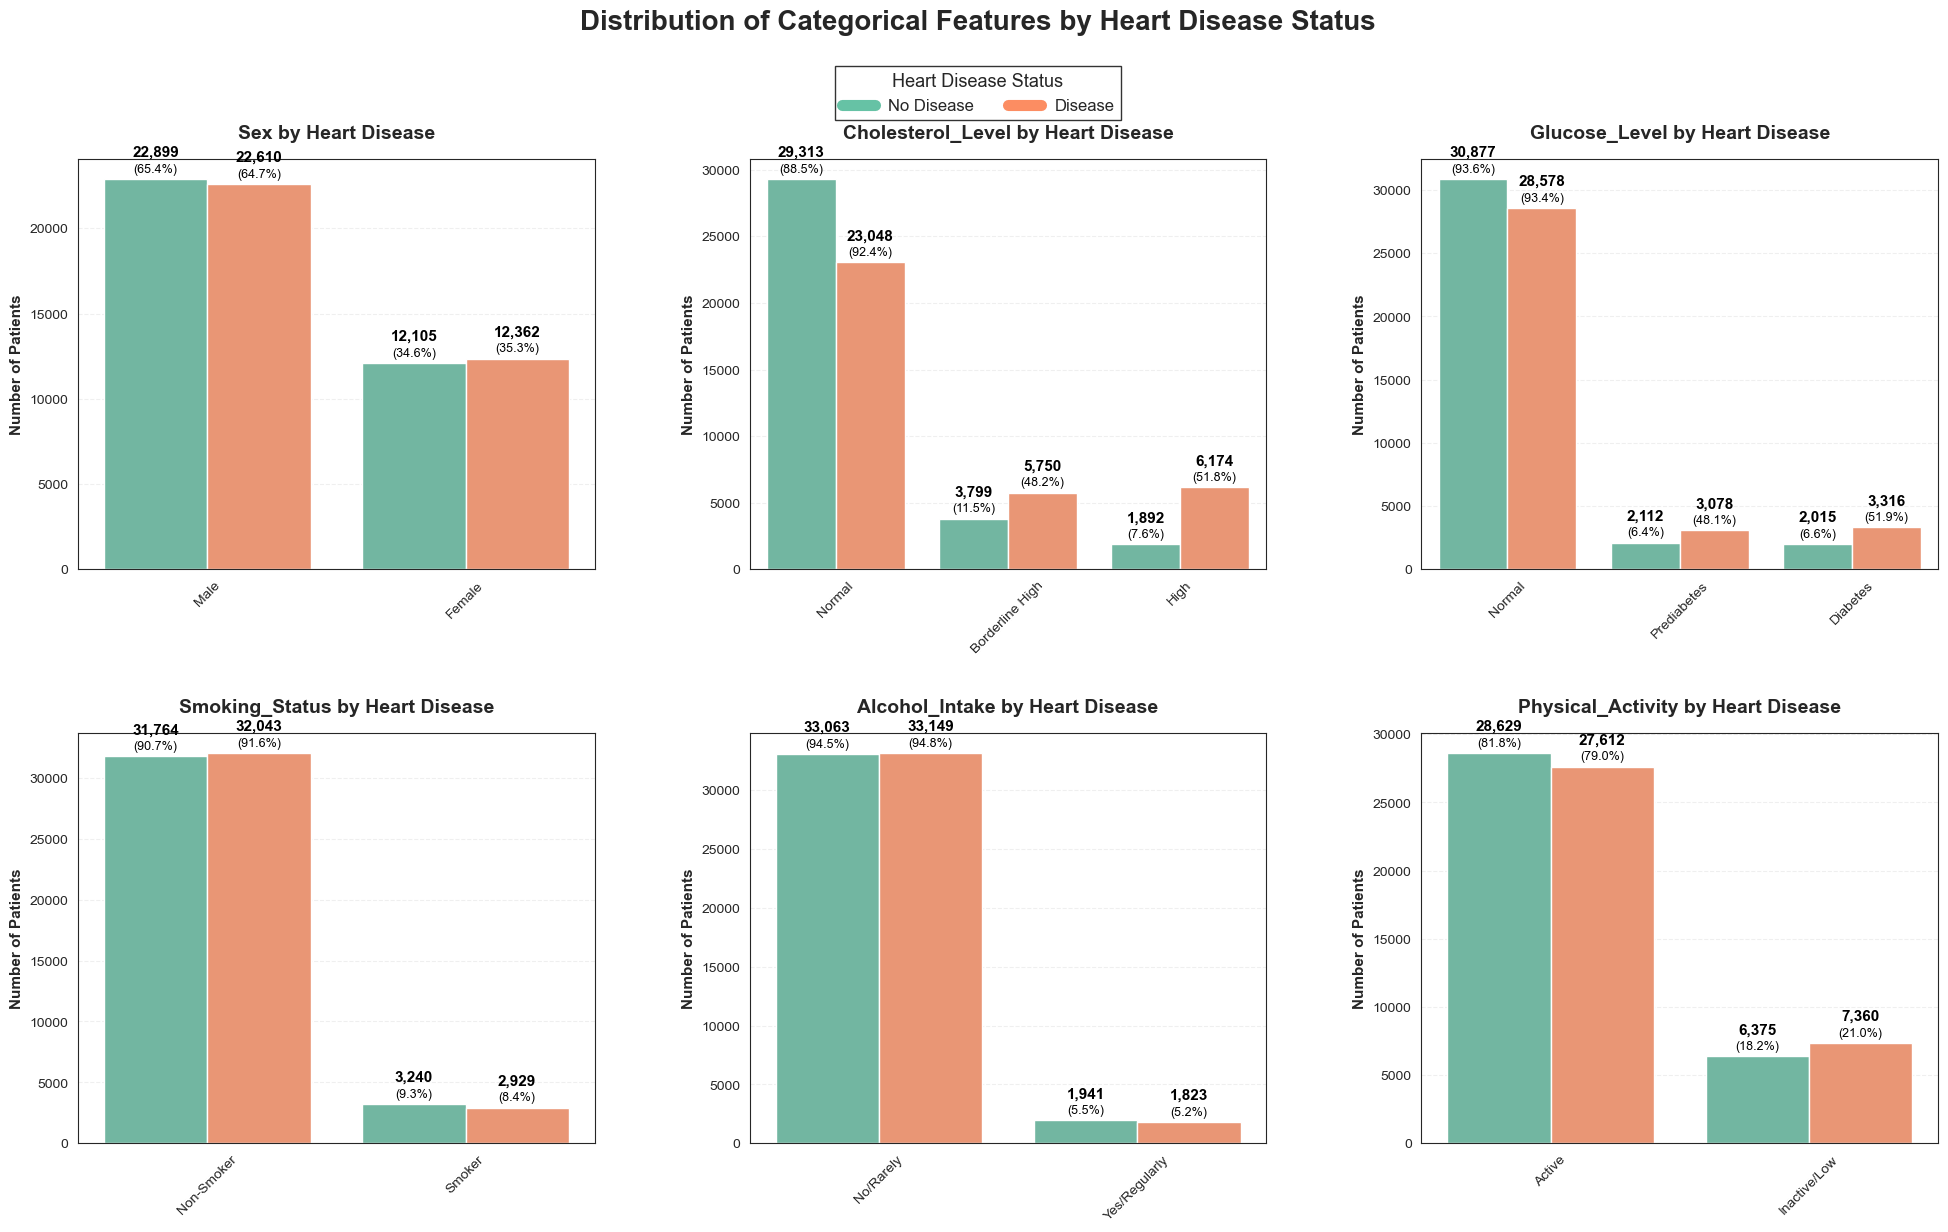

In [124]:
# ==============================================================
# BIVARIATE: CATEGORICAL FEATURES vs TARGET
# ==============================================================
# Categorical features
cat_cols = [
    'Sex', 'Cholesterol_Level', 'Glucose_Level', 
    'Smoking_Status', 'Alcohol_Intake', 'Physical_Activity'
]

# Manual orders
MANUAL_ORDERS = {
    'Cholesterol_Level': ['Normal', 'Borderline High', 'High'],
    'Glucose_Level': ['Normal', 'Prediabetes', 'Diabetes'],
    'Sex': ['Male', 'Female'],
    'Smoking_Status': ['Non-Smoker', 'Smoker'],
    'Alcohol_Intake': ['No/Rarely', 'Yes/Regularly'],
    'Physical_Activity': ['Active', 'Inactive/Low']
}

# Layout setup
n_cols = 3
n_rows = (len(cat_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))
sns.set_style("whitegrid")
axes = axes.flatten()

# Title (at very top)
fig.suptitle('Distribution of Categorical Features by Heart Disease Status',
             fontsize=20, weight='bold', y=0.995)

# Plot each categorical variable
for i, col in enumerate(cat_cols):
    ax = axes[i]
    
    if col not in df.columns:
        continue
    
    # Prepare data
    plot_df = df[[col, 'target']].copy().dropna()
    
    # Map target
    if plot_df['target'].dtype == 'object':
        plot_df['target_name'] = plot_df['target']
    else:
        plot_df['target_name'] = plot_df['target'].map({0: 'No Disease', 1: 'Disease'})
    
    # Determine order
    if col in MANUAL_ORDERS:
        order = [cat for cat in MANUAL_ORDERS[col] if cat in plot_df[col].unique()]
    else:
        if isinstance(plot_df[col].dtype, pd.CategoricalDtype):
            order = list(plot_df[col].cat.categories)
        else:
            try:
                order = sorted(plot_df[col].unique())
            except:
                order = list(plot_df[col].unique())
    
    # Convert numeric to string if needed
    if pd.api.types.is_numeric_dtype(plot_df[col]) and not isinstance(plot_df[col].dtype, pd.CategoricalDtype):
        plot_df[col] = plot_df[col].astype(str)
    
    # Plot
    sns.countplot(
        data=plot_df,
        x=col,
        hue='target_name',
        palette='Set2',
        ax=ax,
        dodge=True,
        legend=False,
        order=order
    )
    
    # Add labels
    patches = ax.patches
    max_height = max([p.get_height() for p in patches]) if patches else 0
    
    for patch_idx, p in enumerate(patches):
        height = p.get_height()
        if height <= 0:
            continue
        
        x_pos = p.get_x() + p.get_width() / 2
        category_idx = patch_idx // 2
        
        if category_idx < len(order):
            category_bars = [patches[category_idx * 2], patches[category_idx * 2 + 1]]
            category_total = sum(bar.get_height() for bar in category_bars)
            percentage = (height / category_total) * 100 if category_total > 0 else 0
        else:
            percentage = 0
        
        # Count (top)
        ax.text(x_pos, height + max_height * 0.05,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=11,
                color='black', fontweight='bold')
        
        # Percentage (below)
        ax.text(x_pos, height + max_height * 0.01,
                f'({percentage:.1f}%)',
                ha='center', va='bottom', fontsize=9,
                color='black')
    
    # Formatting
    ax.set_title(f'{col} by Heart Disease', fontsize=14, pad=15, weight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Number of Patients', fontsize=11, weight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')

# Hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Legend (moved lower to avoid title overlap)
handles = [
    Line2D([0], [0], color=sns.color_palette('Set2')[0], lw=8, label='No Disease'),
    Line2D([0], [0], color=sns.color_palette('Set2')[1], lw=8, label='Disease')
]
fig.legend(
    handles=handles,
    labels=['No Disease', 'Disease'],
    title='Heart Disease Status',
    loc='upper center',
    bbox_to_anchor=(0.5, 0.955),  # Moved down from 0.965
    ncol=2,
    frameon=True,
    fontsize=12,
    title_fontsize=13,
    edgecolor='black',
    fancybox=False
)

# Adjust layout - more space at top
plt.subplots_adjust(left=0.05, right=0.98, top=0.87, bottom=0.05, hspace=0.4, wspace=0.3)

# Save
img_path = BIVARIATE_DIR / '01_categorical_features_vs_target.png'
plt.savefig(img_path, bbox_inches='tight', dpi=150, facecolor='white')
print(f"✓ Saved: {img_path}")

plt.show()
plt.close()


✓ Univariate saved (hidden): p:\projects\heart_disease_prediction\reports\visualizations\univariate_analysis\categorical_analysis\02_sex_distribution.png
✓ Bivariate saved: p:\projects\heart_disease_prediction\reports\visualizations\bivariate_analysis\categorical_analysis\02_sex_vs_target.png


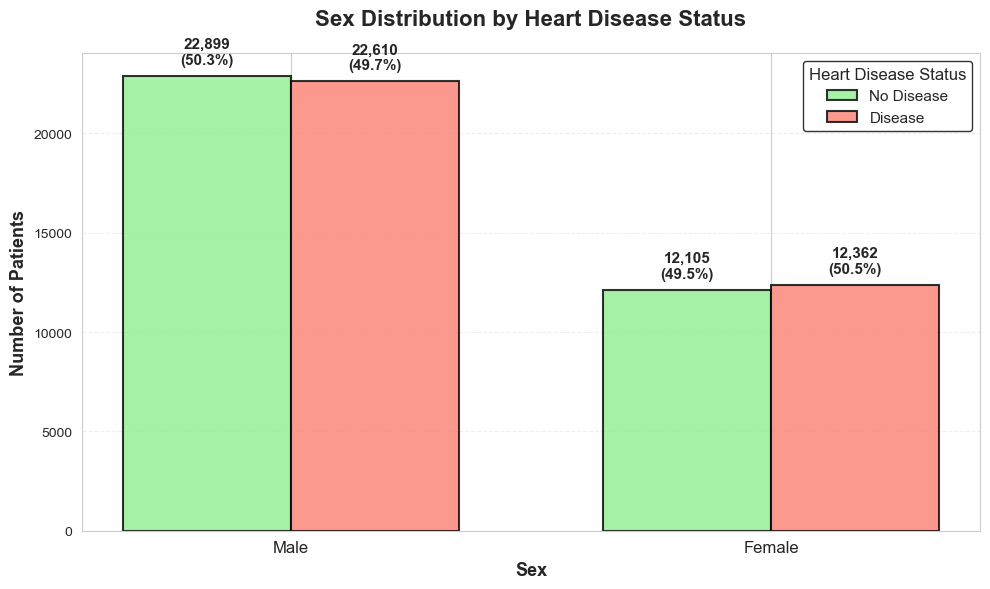

In [125]:
# Feature settings
feature = 'Sex'
order = ['Male', 'Female']
colors_single = ['skyblue', 'lightcoral']
colors_target = ['lightgreen', 'salmon']

# ==============================================================
# UNIVARIATE: SEX DISTRIBUTION 
# ==============================================================

fig, ax = plt.subplots(figsize=(10, 6))

plot_df = df[[feature]].copy().dropna()
counts = plot_df[feature].value_counts().reindex(order)

bars = ax.bar(range(len(counts)), counts.values, color=colors_single, 
              alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_title('Sex Distribution', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Sex', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=13, fontweight='bold')
ax.set_xticks(range(len(counts)))
ax.set_xticklabels(counts.index, fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add labels
max_height = counts.max()
total = counts.sum()
for i, (cat, count) in enumerate(counts.items()):
    pct = (count / total) * 100
    ax.text(i, count + max_height * 0.02,
            f'{int(count):,}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
univariate_path = UNIVARIATE_DIR / '02_sex_distribution.png'
plt.savefig(univariate_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Univariate saved (hidden): {univariate_path}")
plt.close()  # Close without showing

# ==============================================================
# BIVARIATE: SEX vs TARGET
# ==============================================================

fig, ax = plt.subplots(figsize=(10, 6))

plot_df = df[[feature, 'target']].copy().dropna()

# Map target
if plot_df['target'].dtype == 'object':
    plot_df['target_name'] = plot_df['target']
    no_disease_val = 'No Disease'
    disease_val = 'Disease'
else:
    plot_df['target_name'] = plot_df['target'].map({0: 'No Disease', 1: 'Disease'})
    no_disease_val = 'No Disease'
    disease_val = 'Disease'

# Get accurate counts using crosstab
sex_target_crosstab = pd.crosstab(plot_df[feature], plot_df['target_name'])
sex_target_crosstab = sex_target_crosstab.reindex(index=order, columns=[no_disease_val, disease_val], fill_value=0)

# Plot
bar_width = 0.35
x = np.arange(len(order))

bars1 = ax.bar(x - bar_width/2, sex_target_crosstab[no_disease_val], 
               bar_width, label='No Disease', color=colors_target[0],
               alpha=0.8, edgecolor='black', linewidth=1.5)

bars2 = ax.bar(x + bar_width/2, sex_target_crosstab[disease_val], 
               bar_width, label='Disease', color=colors_target[1],
               alpha=0.8, edgecolor='black', linewidth=1.5)

# Add labels
max_height = sex_target_crosstab.values.max()

for i, sex in enumerate(order):
    sex_total = sex_target_crosstab.loc[sex].sum()
    
    # No Disease bar
    no_disease_count = sex_target_crosstab.loc[sex, no_disease_val]
    no_disease_pct = (no_disease_count / sex_total) * 100
    
    ax.text(i - bar_width/2, no_disease_count + max_height * 0.02,
            f'{int(no_disease_count):,}\n({no_disease_pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Disease bar
    disease_count = sex_target_crosstab.loc[sex, disease_val]
    disease_pct = (disease_count / sex_total) * 100
    
    ax.text(i + bar_width/2, disease_count + max_height * 0.02,
            f'{int(disease_count):,}\n({disease_pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_title('Sex Distribution by Heart Disease Status', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Sex', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(order, fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend(title='Heart Disease Status', fontsize=11, title_fontsize=12, 
          loc='upper right', frameon=True, edgecolor='black')

plt.tight_layout()
bivariate_path = BIVARIATE_DIR / '02_sex_vs_target.png'
plt.savefig(bivariate_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Bivariate saved: {bivariate_path}")
plt.show()  # Show only bivariate
plt.close()

* Heart disease is nearly equally distributed between males and females in this dataset, with no strong gender bias. The model should not struggle with classifying by sex, since both groups have similar numbers of cases.

✓ Univariate saved (hidden): p:\projects\heart_disease_prediction\reports\visualizations\univariate_analysis\categorical_analysis\03_cholesterol_distribution.png
✓ Bivariate saved: p:\projects\heart_disease_prediction\reports\visualizations\bivariate_analysis\categorical_analysis\03_cholesterol_vs_target.png


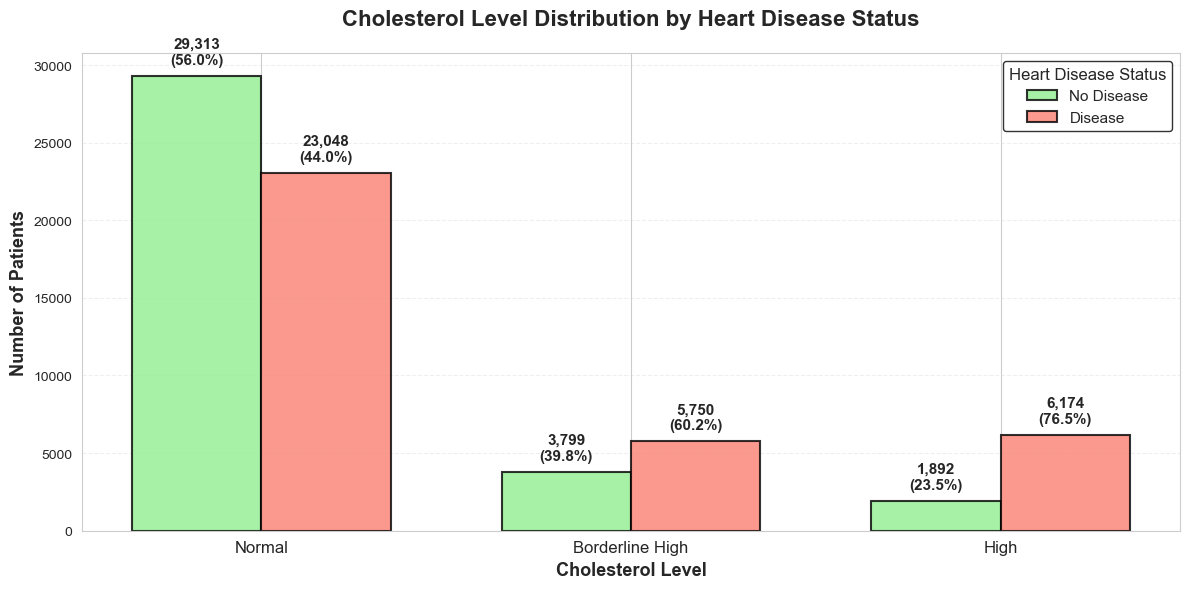

In [126]:
# Feature settings
feature = 'Cholesterol_Level'
order = ['Normal', 'Borderline High', 'High']
colors_single = ['lightgreen', 'gold', 'salmon']
colors_target = ['lightgreen', 'salmon']

# ==============================================================
# UNIVARIATE: CHOLESTEROL DISTRIBUTION (SAVE BUT DON'T SHOW)
# ==============================================================

fig, ax = plt.subplots(figsize=(10, 6))

plot_df = df[[feature]].copy().dropna()
counts = plot_df[feature].value_counts().reindex(order)

bars = ax.bar(range(len(counts)), counts.values, color=colors_single, 
              alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_title('Cholesterol Level Distribution', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Cholesterol Level', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=13, fontweight='bold')
ax.set_xticks(range(len(counts)))
ax.set_xticklabels(counts.index, fontsize=12, rotation=15, ha='right')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add labels
max_height = counts.max()
total = counts.sum()
for i, (cat, count) in enumerate(counts.items()):
    pct = (count / total) * 100
    ax.text(i, count + max_height * 0.02,
            f'{int(count):,}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
univariate_path = UNIVARIATE_DIR / '03_cholesterol_distribution.png'
plt.savefig(univariate_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Univariate saved (hidden): {univariate_path}")
plt.close()

# ==============================================================
# BIVARIATE: CHOLESTEROL vs TARGET (SAVE AND SHOW)
# ==============================================================

fig, ax = plt.subplots(figsize=(12, 6))

plot_df = df[[feature, 'target']].copy().dropna()

# Map target
if plot_df['target'].dtype == 'object':
    plot_df['target_name'] = plot_df['target']
    no_disease_val = 'No Disease'
    disease_val = 'Disease'
else:
    plot_df['target_name'] = plot_df['target'].map({0: 'No Disease', 1: 'Disease'})
    no_disease_val = 'No Disease'
    disease_val = 'Disease'

# Get accurate counts using crosstab
chol_target_crosstab = pd.crosstab(plot_df[feature], plot_df['target_name'])
chol_target_crosstab = chol_target_crosstab.reindex(index=order, columns=[no_disease_val, disease_val], fill_value=0)

# Plot
bar_width = 0.35
x = np.arange(len(order))

bars1 = ax.bar(x - bar_width/2, chol_target_crosstab[no_disease_val], 
               bar_width, label='No Disease', color=colors_target[0],
               alpha=0.8, edgecolor='black', linewidth=1.5)

bars2 = ax.bar(x + bar_width/2, chol_target_crosstab[disease_val], 
               bar_width, label='Disease', color=colors_target[1],
               alpha=0.8, edgecolor='black', linewidth=1.5)

# Add labels
max_height = chol_target_crosstab.values.max()

for i, chol in enumerate(order):
    chol_total = chol_target_crosstab.loc[chol].sum()
    
    # No Disease bar
    no_disease_count = chol_target_crosstab.loc[chol, no_disease_val]
    no_disease_pct = (no_disease_count / chol_total) * 100
    
    ax.text(i - bar_width/2, no_disease_count + max_height * 0.02,
            f'{int(no_disease_count):,}\n({no_disease_pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Disease bar
    disease_count = chol_target_crosstab.loc[chol, disease_val]
    disease_pct = (disease_count / chol_total) * 100
    
    ax.text(i + bar_width/2, disease_count + max_height * 0.02,
            f'{int(disease_count):,}\n({disease_pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_title('Cholesterol Level Distribution by Heart Disease Status', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Cholesterol Level', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(order, fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend(title='Heart Disease Status', fontsize=11, title_fontsize=12, 
          loc='upper right', frameon=True, edgecolor='black')

plt.tight_layout()
bivariate_path = BIVARIATE_DIR / '03_cholesterol_vs_target.png'
plt.savefig(bivariate_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Bivariate saved: {bivariate_path}")
plt.show()
plt.close()

* Higher cholesterol levels are strongly associated with heart disease, especially in the high cholesterol group. However, because most patients have normal cholesterol, this can dominate the model’s learning and potentially mislead the model into underestimating heart disease risk in the smaller high cholesterol group. As a result, the model may struggle to accurately classify patients with high cholesterol due to this imbalance.

✓ Univariate saved (hidden): p:\projects\heart_disease_prediction\reports\visualizations\univariate_analysis\categorical_analysis\04_glucose_distribution.png
✓ Bivariate saved: p:\projects\heart_disease_prediction\reports\visualizations\bivariate_analysis\categorical_analysis\04_glucose_vs_target.png


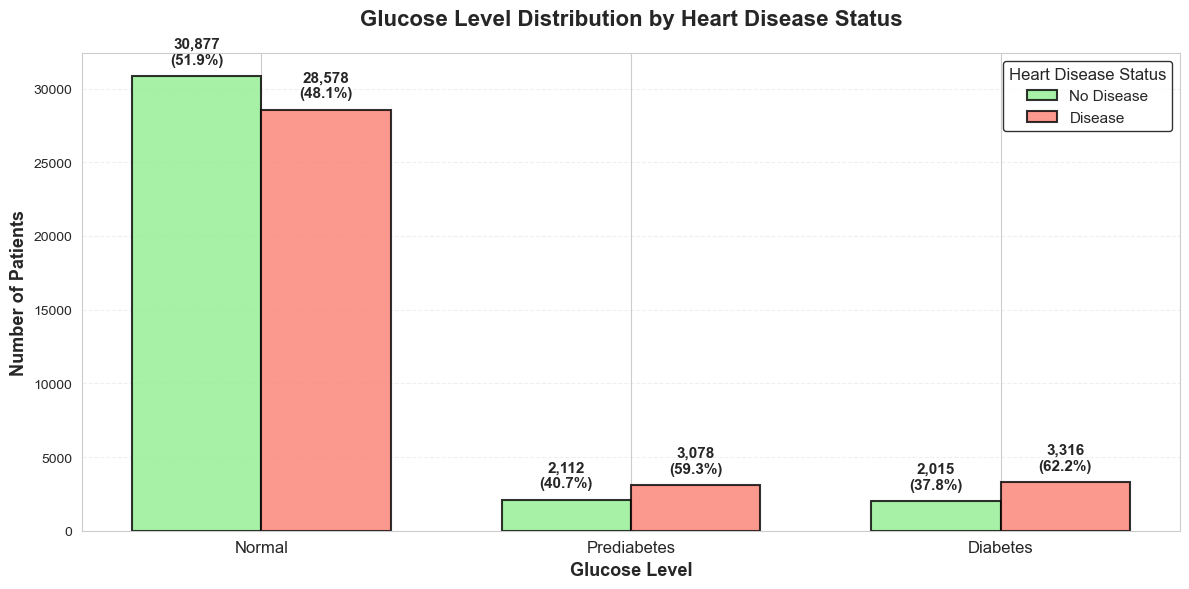

In [127]:
# Feature settings
feature = 'Glucose_Level'
order = ['Normal', 'Prediabetes', 'Diabetes']
colors_single = ['lightgreen', 'gold', 'salmon']
colors_target = ['lightgreen', 'salmon']

# ==============================================================
# UNIVARIATE: GLUCOSE DISTRIBUTION (SAVE BUT DON'T SHOW)
# ==============================================================

fig, ax = plt.subplots(figsize=(10, 6))

plot_df = df[[feature]].copy().dropna()
counts = plot_df[feature].value_counts().reindex(order)

bars = ax.bar(range(len(counts)), counts.values, color=colors_single, 
              alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_title('Glucose Level Distribution', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Glucose Level', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=13, fontweight='bold')
ax.set_xticks(range(len(counts)))
ax.set_xticklabels(counts.index, fontsize=12, rotation=15, ha='right')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add labels
max_height = counts.max()
total = counts.sum()
for i, (cat, count) in enumerate(counts.items()):
    pct = (count / total) * 100
    ax.text(i, count + max_height * 0.02,
            f'{int(count):,}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
univariate_path = UNIVARIATE_DIR / '04_glucose_distribution.png'
plt.savefig(univariate_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Univariate saved (hidden): {univariate_path}")
plt.close()

# ==============================================================
# BIVARIATE: GLUCOSE vs TARGET (SAVE AND SHOW)
# ==============================================================

fig, ax = plt.subplots(figsize=(12, 6))

plot_df = df[[feature, 'target']].copy().dropna()

# Map target
if plot_df['target'].dtype == 'object':
    plot_df['target_name'] = plot_df['target']
    no_disease_val = 'No Disease'
    disease_val = 'Disease'
else:
    plot_df['target_name'] = plot_df['target'].map({0: 'No Disease', 1: 'Disease'})
    no_disease_val = 'No Disease'
    disease_val = 'Disease'

# Get accurate counts using crosstab
glucose_target_crosstab = pd.crosstab(plot_df[feature], plot_df['target_name'])
glucose_target_crosstab = glucose_target_crosstab.reindex(index=order, columns=[no_disease_val, disease_val], fill_value=0)

# Plot
bar_width = 0.35
x = np.arange(len(order))

bars1 = ax.bar(x - bar_width/2, glucose_target_crosstab[no_disease_val], 
               bar_width, label='No Disease', color=colors_target[0],
               alpha=0.8, edgecolor='black', linewidth=1.5)

bars2 = ax.bar(x + bar_width/2, glucose_target_crosstab[disease_val], 
               bar_width, label='Disease', color=colors_target[1],
               alpha=0.8, edgecolor='black', linewidth=1.5)

# Add labels
max_height = glucose_target_crosstab.values.max()

for i, glucose in enumerate(order):
    glucose_total = glucose_target_crosstab.loc[glucose].sum()
    
    # No Disease bar
    no_disease_count = glucose_target_crosstab.loc[glucose, no_disease_val]
    no_disease_pct = (no_disease_count / glucose_total) * 100
    
    ax.text(i - bar_width/2, no_disease_count + max_height * 0.02,
            f'{int(no_disease_count):,}\n({no_disease_pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Disease bar
    disease_count = glucose_target_crosstab.loc[glucose, disease_val]
    disease_pct = (disease_count / glucose_total) * 100
    
    ax.text(i + bar_width/2, disease_count + max_height * 0.02,
            f'{int(disease_count):,}\n({disease_pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_title('Glucose Level Distribution by Heart Disease Status', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Glucose Level', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(order, fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend(title='Heart Disease Status', fontsize=11, title_fontsize=12, 
          loc='upper right', frameon=True, edgecolor='black')

plt.tight_layout()
bivariate_path = BIVARIATE_DIR / '04_glucose_vs_target.png'
plt.savefig(bivariate_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Bivariate saved: {bivariate_path}")
plt.show()
plt.close()

* Most patients have normal glucose levels, and heart disease is much more frequent in those with prediabetes and diabetes. The dominance of the normal glucose group could mislead the model and cause poor performance when predicting disease risk in the smaller, high-risk diabetic group.

✓ Univariate saved (hidden): p:\projects\heart_disease_prediction\reports\visualizations\univariate_analysis\categorical_analysis\05_smoking_distribution.png
✓ Bivariate saved: p:\projects\heart_disease_prediction\reports\visualizations\bivariate_analysis\categorical_analysis\05_smoking_vs_target.png


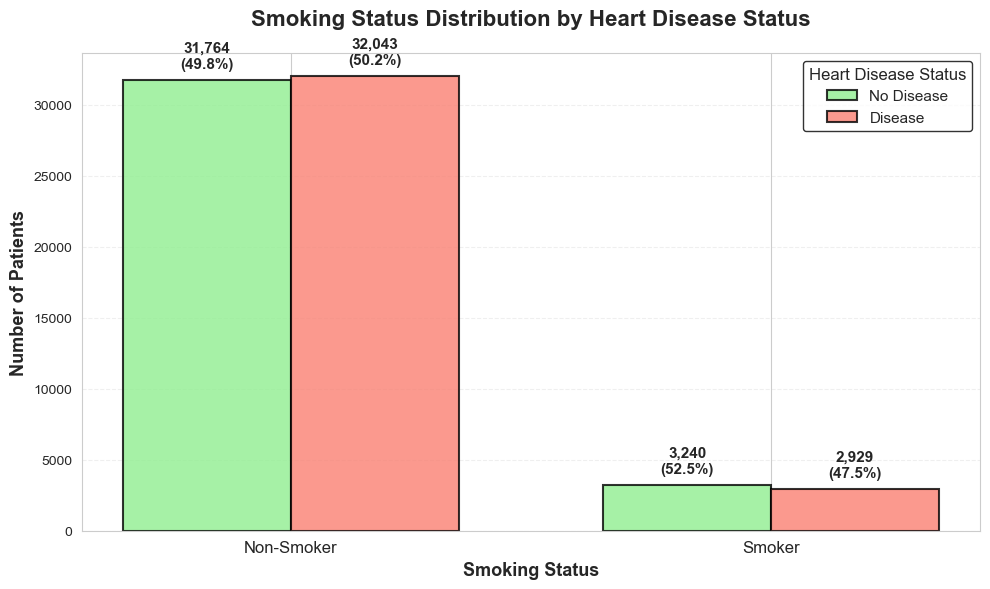

In [128]:
# Feature settings
feature = 'Smoking_Status'
order = ['Non-Smoker', 'Smoker']
colors_single = ['lightgreen', 'lightcoral']
colors_target = ['lightgreen', 'salmon']

# ==============================================================
# UNIVARIATE: SMOKING DISTRIBUTION (SAVE BUT DON'T SHOW)
# ==============================================================

fig, ax = plt.subplots(figsize=(10, 6))

plot_df = df[[feature]].copy().dropna()
counts = plot_df[feature].value_counts().reindex(order)

bars = ax.bar(range(len(counts)), counts.values, color=colors_single, 
              alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_title('Smoking Status Distribution', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Smoking Status', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=13, fontweight='bold')
ax.set_xticks(range(len(counts)))
ax.set_xticklabels(counts.index, fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add labels
max_height = counts.max()
total = counts.sum()
for i, (cat, count) in enumerate(counts.items()):
    pct = (count / total) * 100
    ax.text(i, count + max_height * 0.02,
            f'{int(count):,}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
univariate_path = UNIVARIATE_DIR / '05_smoking_distribution.png'
plt.savefig(univariate_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Univariate saved (hidden): {univariate_path}")
plt.close()

# ==============================================================
# BIVARIATE: SMOKING vs TARGET (SAVE AND SHOW)
# ==============================================================

fig, ax = plt.subplots(figsize=(10, 6))

plot_df = df[[feature, 'target']].copy().dropna()

# Map target
if plot_df['target'].dtype == 'object':
    plot_df['target_name'] = plot_df['target']
    no_disease_val = 'No Disease'
    disease_val = 'Disease'
else:
    plot_df['target_name'] = plot_df['target'].map({0: 'No Disease', 1: 'Disease'})
    no_disease_val = 'No Disease'
    disease_val = 'Disease'

# Get accurate counts using crosstab
smoking_target_crosstab = pd.crosstab(plot_df[feature], plot_df['target_name'])
smoking_target_crosstab = smoking_target_crosstab.reindex(index=order, columns=[no_disease_val, disease_val], fill_value=0)

# Plot
bar_width = 0.35
x = np.arange(len(order))

bars1 = ax.bar(x - bar_width/2, smoking_target_crosstab[no_disease_val], 
               bar_width, label='No Disease', color=colors_target[0],
               alpha=0.8, edgecolor='black', linewidth=1.5)

bars2 = ax.bar(x + bar_width/2, smoking_target_crosstab[disease_val], 
               bar_width, label='Disease', color=colors_target[1],
               alpha=0.8, edgecolor='black', linewidth=1.5)

# Add labels
max_height = smoking_target_crosstab.values.max()

for i, smoking in enumerate(order):
    smoking_total = smoking_target_crosstab.loc[smoking].sum()
    
    # No Disease bar
    no_disease_count = smoking_target_crosstab.loc[smoking, no_disease_val]
    no_disease_pct = (no_disease_count / smoking_total) * 100
    
    ax.text(i - bar_width/2, no_disease_count + max_height * 0.02,
            f'{int(no_disease_count):,}\n({no_disease_pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Disease bar
    disease_count = smoking_target_crosstab.loc[smoking, disease_val]
    disease_pct = (disease_count / smoking_total) * 100
    
    ax.text(i + bar_width/2, disease_count + max_height * 0.02,
            f'{int(disease_count):,}\n({disease_pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_title('Smoking Status Distribution by Heart Disease Status', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Smoking Status', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(order, fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend(title='Heart Disease Status', fontsize=11, title_fontsize=12, 
          loc='upper right', frameon=True, edgecolor='black')

plt.tight_layout()
bivariate_path = BIVARIATE_DIR / '05_smoking_vs_target.png'
plt.savefig(bivariate_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Bivariate saved: {bivariate_path}")
plt.show()
plt.close()

* Smoking is not strongly associated with heart disease in this dataset, as both smokers and non-smokers have similar rates of disease. Because the vast majority of patients are non-smokers, the model could become biased or misled by this dominant group, making it less reliable for predictions specifically among smokers.

✓ Univariate saved (hidden): p:\projects\heart_disease_prediction\reports\visualizations\univariate_analysis\categorical_analysis\06_alcohol_distribution.png
✓ Bivariate saved: p:\projects\heart_disease_prediction\reports\visualizations\bivariate_analysis\categorical_analysis\06_alcohol_vs_target.png


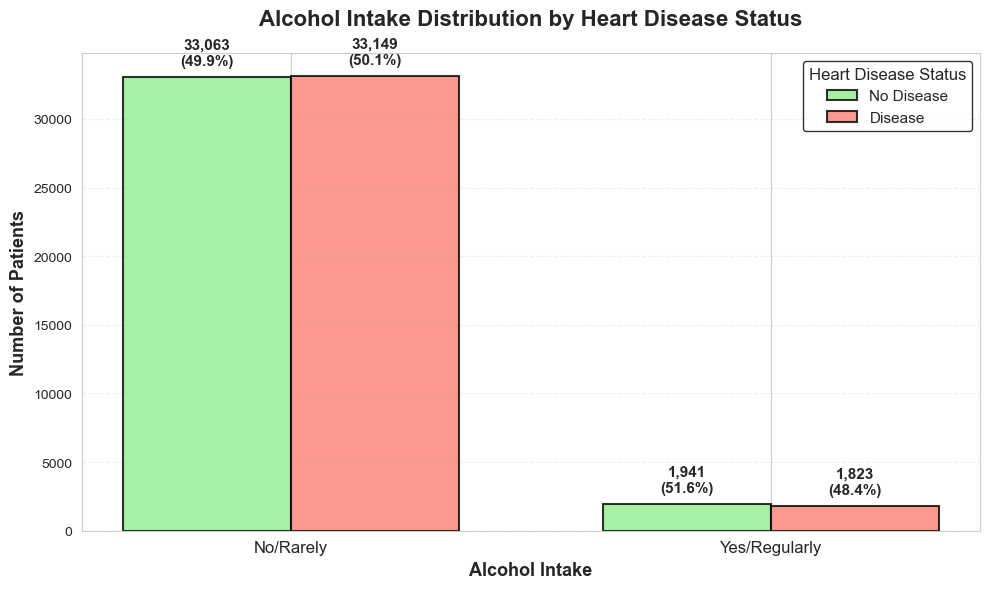

In [129]:
# Feature settings
feature = 'Alcohol_Intake'
order = ['No/Rarely', 'Yes/Regularly']
colors_single = ['lightgreen', 'lightcoral']
colors_target = ['lightgreen', 'salmon']

# ==============================================================
# UNIVARIATE: ALCOHOL DISTRIBUTION (SAVE BUT DON'T SHOW)
# ==============================================================

fig, ax = plt.subplots(figsize=(10, 6))

plot_df = df[[feature]].copy().dropna()
counts = plot_df[feature].value_counts().reindex(order)

bars = ax.bar(range(len(counts)), counts.values, color=colors_single, 
              alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_title('Alcohol Intake Distribution', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Alcohol Intake', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=13, fontweight='bold')
ax.set_xticks(range(len(counts)))
ax.set_xticklabels(counts.index, fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add labels
max_height = counts.max()
total = counts.sum()
for i, (cat, count) in enumerate(counts.items()):
    pct = (count / total) * 100
    ax.text(i, count + max_height * 0.02,
            f'{int(count):,}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
univariate_path = UNIVARIATE_DIR / '06_alcohol_distribution.png'
plt.savefig(univariate_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Univariate saved (hidden): {univariate_path}")
plt.close()

# ==============================================================
# BIVARIATE: ALCOHOL vs TARGET (SAVE AND SHOW)
# ==============================================================

fig, ax = plt.subplots(figsize=(10, 6))

plot_df = df[[feature, 'target']].copy().dropna()

# Map target
if plot_df['target'].dtype == 'object':
    plot_df['target_name'] = plot_df['target']
    no_disease_val = 'No Disease'
    disease_val = 'Disease'
else:
    plot_df['target_name'] = plot_df['target'].map({0: 'No Disease', 1: 'Disease'})
    no_disease_val = 'No Disease'
    disease_val = 'Disease'

# Get accurate counts using crosstab
alcohol_target_crosstab = pd.crosstab(plot_df[feature], plot_df['target_name'])
alcohol_target_crosstab = alcohol_target_crosstab.reindex(index=order, columns=[no_disease_val, disease_val], fill_value=0)

# Plot
bar_width = 0.35
x = np.arange(len(order))

bars1 = ax.bar(x - bar_width/2, alcohol_target_crosstab[no_disease_val], 
               bar_width, label='No Disease', color=colors_target[0],
               alpha=0.8, edgecolor='black', linewidth=1.5)

bars2 = ax.bar(x + bar_width/2, alcohol_target_crosstab[disease_val], 
               bar_width, label='Disease', color=colors_target[1],
               alpha=0.8, edgecolor='black', linewidth=1.5)

# Add labels
max_height = alcohol_target_crosstab.values.max()

for i, alcohol in enumerate(order):
    alcohol_total = alcohol_target_crosstab.loc[alcohol].sum()
    
    # No Disease bar
    no_disease_count = alcohol_target_crosstab.loc[alcohol, no_disease_val]
    no_disease_pct = (no_disease_count / alcohol_total) * 100
    
    ax.text(i - bar_width/2, no_disease_count + max_height * 0.02,
            f'{int(no_disease_count):,}\n({no_disease_pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Disease bar
    disease_count = alcohol_target_crosstab.loc[alcohol, disease_val]
    disease_pct = (disease_count / alcohol_total) * 100
    
    ax.text(i + bar_width/2, disease_count + max_height * 0.02,
            f'{int(disease_count):,}\n({disease_pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_title('Alcohol Intake Distribution by Heart Disease Status', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Alcohol Intake', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(order, fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend(title='Heart Disease Status', fontsize=11, title_fontsize=12, 
          loc='upper right', frameon=True, edgecolor='black')

plt.tight_layout()
bivariate_path = BIVARIATE_DIR / '06_alcohol_vs_target.png'
plt.savefig(bivariate_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Bivariate saved: {bivariate_path}")
plt.show()
plt.close()

* Alcohol intake shows almost no difference in heart disease rates between groups, with most patients being non-drinkers or rare drinkers. This imbalance means the model might focus too much on the majority group and fail to detect small patterns or disease risk in regular alcohol users.

✓ Univariate saved (hidden): p:\projects\heart_disease_prediction\reports\visualizations\univariate_analysis\categorical_analysis\07_physical_activity_distribution.png
✓ Bivariate saved: p:\projects\heart_disease_prediction\reports\visualizations\bivariate_analysis\categorical_analysis\07_physical_activity_vs_target.png


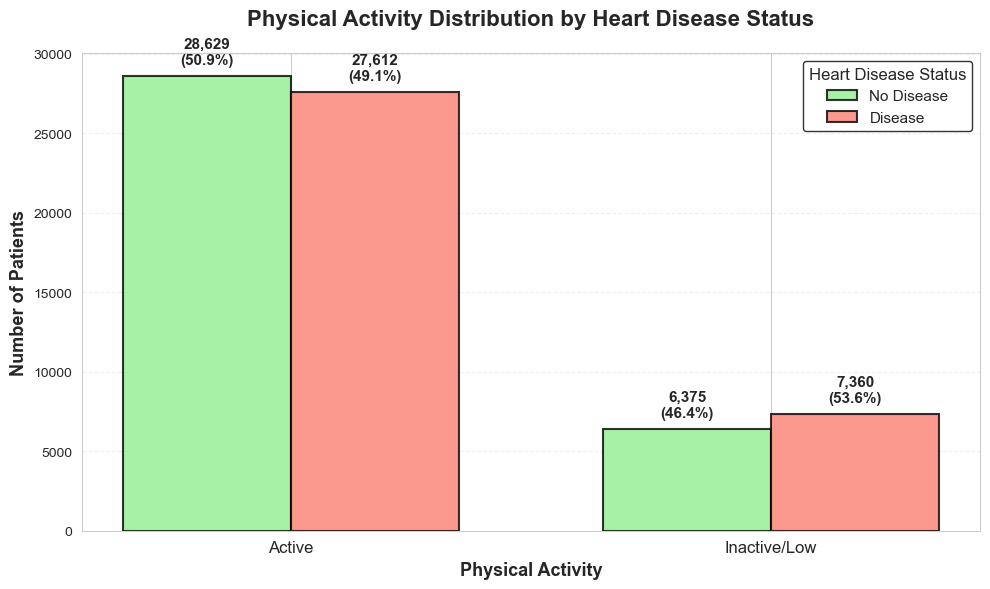

In [130]:
# Feature settings
feature = 'Physical_Activity'
order = ['Active', 'Inactive/Low']
colors_single = ['lightgreen', 'lightcoral']
colors_target = ['lightgreen', 'salmon']

# ==============================================================
# UNIVARIATE: PHYSICAL ACTIVITY DISTRIBUTION (SAVE BUT DON'T SHOW)
# ==============================================================

fig, ax = plt.subplots(figsize=(10, 6))

plot_df = df[[feature]].copy().dropna()
counts = plot_df[feature].value_counts().reindex(order)

bars = ax.bar(range(len(counts)), counts.values, color=colors_single, 
              alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_title('Physical Activity Distribution', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Physical Activity', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=13, fontweight='bold')
ax.set_xticks(range(len(counts)))
ax.set_xticklabels(counts.index, fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add labels
max_height = counts.max()
total = counts.sum()
for i, (cat, count) in enumerate(counts.items()):
    pct = (count / total) * 100
    ax.text(i, count + max_height * 0.02,
            f'{int(count):,}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
univariate_path = UNIVARIATE_DIR / '07_physical_activity_distribution.png'
plt.savefig(univariate_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Univariate saved (hidden): {univariate_path}")
plt.close()

# ==============================================================
# BIVARIATE: PHYSICAL ACTIVITY vs TARGET (SAVE AND SHOW)
# ==============================================================

fig, ax = plt.subplots(figsize=(10, 6))

plot_df = df[[feature, 'target']].copy().dropna()

# Map target
if plot_df['target'].dtype == 'object':
    plot_df['target_name'] = plot_df['target']
    no_disease_val = 'No Disease'
    disease_val = 'Disease'
else:
    plot_df['target_name'] = plot_df['target'].map({0: 'No Disease', 1: 'Disease'})
    no_disease_val = 'No Disease'
    disease_val = 'Disease'

# Get accurate counts using crosstab
activity_target_crosstab = pd.crosstab(plot_df[feature], plot_df['target_name'])
activity_target_crosstab = activity_target_crosstab.reindex(index=order, columns=[no_disease_val, disease_val], fill_value=0)

# Plot
bar_width = 0.35
x = np.arange(len(order))

bars1 = ax.bar(x - bar_width/2, activity_target_crosstab[no_disease_val], 
               bar_width, label='No Disease', color=colors_target[0],
               alpha=0.8, edgecolor='black', linewidth=1.5)

bars2 = ax.bar(x + bar_width/2, activity_target_crosstab[disease_val], 
               bar_width, label='Disease', color=colors_target[1],
               alpha=0.8, edgecolor='black', linewidth=1.5)

# Add labels
max_height = activity_target_crosstab.values.max()

for i, activity in enumerate(order):
    activity_total = activity_target_crosstab.loc[activity].sum()
    
    # No Disease bar
    no_disease_count = activity_target_crosstab.loc[activity, no_disease_val]
    no_disease_pct = (no_disease_count / activity_total) * 100
    
    ax.text(i - bar_width/2, no_disease_count + max_height * 0.02,
            f'{int(no_disease_count):,}\n({no_disease_pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Disease bar
    disease_count = activity_target_crosstab.loc[activity, disease_val]
    disease_pct = (disease_count / activity_total) * 100
    
    ax.text(i + bar_width/2, disease_count + max_height * 0.02,
            f'{int(disease_count):,}\n({disease_pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_title('Physical Activity Distribution by Heart Disease Status', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Physical Activity', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(order, fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend(title='Heart Disease Status', fontsize=11, title_fontsize=12, 
          loc='upper right', frameon=True, edgecolor='black')

plt.tight_layout()
bivariate_path = BIVARIATE_DIR / '07_physical_activity_vs_target.png'
plt.savefig(bivariate_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Bivariate saved: {bivariate_path}")
plt.show()
plt.close()

* Physically inactive patients have a slightly higher rate of heart disease, but most patients are in the active group. This imbalance means the model could focus mainly on active patients and struggle to accurately classify the smaller group of inactive individuals.

In [131]:
# Categorical features
cat_cols = ['Sex', 'Cholesterol_Level', 'Glucose_Level', 'Smoking_Status', 'Alcohol_Intake', 'Physical_Activity']

print(f"\n✓ Analyzing {len(cat_cols)} categorical features")
print(f"✓ Target distribution: {df['target'].value_counts().to_dict()}")

results = []

# Process each feature
for col in cat_cols:
    if col not in df.columns:
        continue
    
    # Contingency table
    contingency = pd.crosstab(df[col], df['target'])
    chi2, p_value, _, expected = chi2_contingency(contingency)
    cramers_v = association(contingency, method='cramer')
    
    # Effect size
    if cramers_v < 0.1:
        effect = "Negligible"
    elif cramers_v < 0.3:
        effect = "Small"
    elif cramers_v < 0.5:
        effect = "Medium"
    else:
        effect = "Large"
    
    results.append({
        "Feature": col,
        "Chi2": round(chi2, 2),
        "p_value": round(p_value, 4),
        "Cramers_V": round(cramers_v, 4),
        "Effect": effect,
    })

# Results DataFrame
results_df = pd.DataFrame(results).sort_values('Cramers_V', ascending=False)
print(results_df.to_string(index=False))


✓ Analyzing 6 categorical features
✓ Target distribution: {'No Disease': 35004, 'Disease': 34972}
          Feature    Chi2  p_value  Cramers_V     Effect
Cholesterol_Level 3421.40   0.0000     0.2211      Small
    Glucose_Level  586.18   0.0000     0.0915 Negligible
Physical_Activity   88.84   0.0000     0.0357 Negligible
   Smoking_Status   16.77   0.0000     0.0155 Negligible
              Sex    4.49   0.0342     0.0080 Negligible
   Alcohol_Intake    3.73   0.0534     0.0074 Negligible


### Multivariate analysis

In [132]:
# ============================================================================
# PATH SETUP
# ============================================================================

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT != PROJECT_ROOT.parent:
    PROJECT_ROOT = PROJECT_ROOT.parent

# Visualization directory
VIZ_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'multivariate_analysis'
if not VIZ_DIR.exists():
    VIZ_DIR.mkdir(parents=True, exist_ok=True)
    print(f"✓ Created directory: {VIZ_DIR}")
else:
    print(f"✓ Using existing directory: {VIZ_DIR}")

✓ Using existing directory: p:\projects\heart_disease_prediction\reports\visualizations\multivariate_analysis


In [133]:
# Convert target
if df['target'].dtype == 'object':
    df['target'] = df['target'].map({'No Disease': 0, 'Disease': 1})
df['target'] = pd.to_numeric(df['target'], errors='coerce')

# Cholesterol
if df['Cholesterol_Level'].dtype == 'object':
    chol_map = {'Normal': 180, 'Borderline High': 220, 'High': 260}
    df['Cholesterol_Level'] = df['Cholesterol_Level'].map(chol_map)
print("✓ Cholesterol standardized to mg/dL")
print(df['Cholesterol_Level'].value_counts())

# Glucose
glucose_col = 'Glucose_Level' if 'Glucose_Level' in df.columns else 'Glucose_level'
if df[glucose_col].dtype == 'object':
    glu_map = {'Normal': 90, 'Prediabetes': 110, 'Diabetes': 140}
    df['Glucose_Level'] = df[glucose_col].map(glu_map)
else:
    df['Glucose_Level'] = df[glucose_col]
print("✓ Glucose standardized to mg/dL")
print(df['Glucose_Level'].value_counts())

for col in ['Age_Years', 'Systolic_BP', 'Diastolic_BP', 'BMI']:
    df[col] = pd.to_numeric(df[col], errors='coerce')


✓ Cholesterol standardized to mg/dL
180    52361
220     9549
260     8066
Name: Cholesterol_Level, dtype: int64
✓ Glucose standardized to mg/dL
90     59455
140     5331
110     5190
Name: Glucose_Level, dtype: int64


CREATING TWO SEPARATE FEATURES:
  1. Systolic_Age_risk (Direct relationship)
  2. Diastolic_Age_risk (Independent relationship)

[1/7] Validating dtypes...
✓ All dtypes validated

[2/7] Creating age risk component...
✓ Age risk range: [0.50, 4.13]

[3/7] Creating Systolic BP risk...
✓ Systolic risk range: [1.00, 5.00]

[4/7] Creating Diastolic BP risk...
✓ Diastolic risk range: [1.00, 4.00]

[5/7] Creating separate interaction features...
✓ Systolic_Age_risk_raw range: [0.50, 20.59]
✓ Diastolic_Age_risk_raw range: [0.50, 16.45]

[6/7] Scaling both features...
✓ Systolic_Age_risk scaled: [-0.62, 3.14]
✓ Diastolic_Age_risk scaled: [-0.81, 4.09]

[7/7] Feature quality comparison...

FEATURE QUALITY COMPARISON
Metric                Systolic_Age_risk Diastolic_Age_risk
----------------------------------------------------------------------
Cohen d                           0.873              0.703
AUC                               0.760              0.712
Spearman rho                      0.

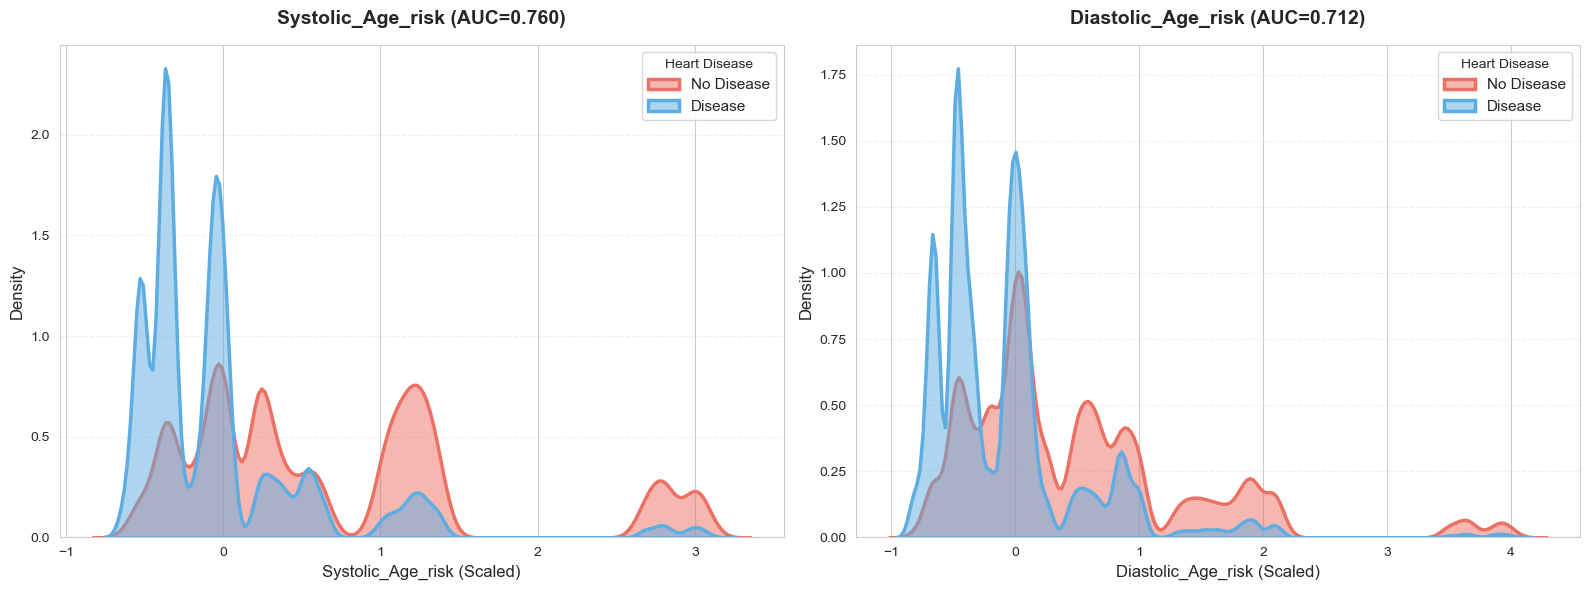


[9/9] Cleaning up temporary columns...
✓ Kept features: Systolic_Age_risk, Diastolic_Age_risk
✓ Final dataset shape: (69976, 13)

✅ TWO SEPARATE BP-AGE FEATURES CREATED


In [134]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from scipy.stats import spearmanr

# ============================================================================
# SYSTOLIC_AGE_RISK & DIASTOLIC_AGE_RISK (SEPARATE FEATURES)
# ============================================================================

print("="*70)
print("CREATING TWO SEPARATE FEATURES:")
print("  1. Systolic_Age_risk (Direct relationship)")
print("  2. Diastolic_Age_risk (Independent relationship)")
print("="*70)

# ============================================================================
# 1. DTYPE VALIDATION
# ============================================================================
print("\n[1/7] Validating dtypes...")

for col in ['Age_Years', 'Systolic_BP', 'Diastolic_BP']:
    df[col] = pd.to_numeric(df[col], errors='coerce').astype(float)

if df['target'].dtype == 'object':
    df['target'] = df['target'].map({'No Disease': 0, 'Disease': 1})
df['target'] = pd.to_numeric(df['target'], errors='coerce').astype(int)

print(f"✓ All dtypes validated")

# ============================================================================
# 2. AGE RISK (SHARED BY BOTH FEATURES)
# ============================================================================
print("\n[2/7] Creating age risk component...")

def calculate_age_risk(age):
    """Hybrid: Base + Exponential + Polynomial"""
    if age < 30:
        base = 0.25
    elif age < 40:
        base = 0.50
    elif age < 50:
        base = 1.00
    elif age < 60:
        base = 1.80
    elif age < 70:
        base = 3.20
    else:
        base = 5.50
    
    exp_boost = np.exp(0.035 * (age - 50)) - 1.0 if age >= 50 else 0
    poly_boost = ((age - 60) ** 2) / 100 if age >= 60 else 0
    
    return base + exp_boost + poly_boost

df['age_risk'] = df['Age_Years'].apply(calculate_age_risk).astype(float)
print(f"✓ Age risk range: [{df['age_risk'].min():.2f}, {df['age_risk'].max():.2f}]")

# ============================================================================
# 3. SYSTOLIC BP RISK (DIRECT RELATIONSHIP)
# ============================================================================
print("\n[3/7] Creating Systolic BP risk...")

def get_systolic_risk(systolic):
    """Based on ACC/AHA guidelines"""
    if systolic < 120:
        return 1.0
    elif systolic < 130:
        return 1.8
    elif systolic < 140:
        return 2.8
    else:
        return 5.0

df['systolic_risk'] = df['Systolic_BP'].apply(get_systolic_risk).astype(float)
print(f"✓ Systolic risk range: [{df['systolic_risk'].min():.2f}, {df['systolic_risk'].max():.2f}]")

# ============================================================================
# 4. DIASTOLIC BP RISK (INDEPENDENT RELATIONSHIP)
# ============================================================================
print("\n[4/7] Creating Diastolic BP risk...")

def get_diastolic_risk(diastolic):
    """Standalone diastolic risk (not merged with systolic)"""
    if diastolic < 80:
        return 1.0
    elif diastolic < 90:
        return 1.6
    elif diastolic < 100:
        return 2.5
    else:
        return 4.0

df['diastolic_risk'] = df['Diastolic_BP'].apply(get_diastolic_risk).astype(float)
print(f"✓ Diastolic risk range: [{df['diastolic_risk'].min():.2f}, {df['diastolic_risk'].max():.2f}]")

# ============================================================================
# 5. CREATE TWO SEPARATE INTERACTION FEATURES
# ============================================================================
print("\n[5/7] Creating separate interaction features...")

# Feature 1: Systolic × Age
df['Systolic_Age_risk_raw'] = (df['systolic_risk'] * df['age_risk']).astype(float)

# Feature 2: Diastolic × Age
df['Diastolic_Age_risk_raw'] = (df['diastolic_risk'] * df['age_risk']).astype(float)

print(f"✓ Systolic_Age_risk_raw range: [{df['Systolic_Age_risk_raw'].min():.2f}, {df['Systolic_Age_risk_raw'].max():.2f}]")
print(f"✓ Diastolic_Age_risk_raw range: [{df['Diastolic_Age_risk_raw'].min():.2f}, {df['Diastolic_Age_risk_raw'].max():.2f}]")

# ============================================================================
# 6. SCALE BOTH FEATURES
# ============================================================================
print("\n[6/7] Scaling both features...")

scaler_sys = RobustScaler(quantile_range=(25, 75))
df['Systolic_Age_risk'] = scaler_sys.fit_transform(df[['Systolic_Age_risk_raw']]).astype(float)

scaler_dia = RobustScaler(quantile_range=(25, 75))
df['Diastolic_Age_risk'] = scaler_dia.fit_transform(df[['Diastolic_Age_risk_raw']]).astype(float)

print(f"✓ Systolic_Age_risk scaled: [{df['Systolic_Age_risk'].min():.2f}, {df['Systolic_Age_risk'].max():.2f}]")
print(f"✓ Diastolic_Age_risk scaled: [{df['Diastolic_Age_risk'].min():.2f}, {df['Diastolic_Age_risk'].max():.2f}]")

# ============================================================================
# 7. FEATURE QUALITY METRICS (BOTH FEATURES)
# ============================================================================
print("\n[7/7] Feature quality comparison...")

def compute_metrics(feature_name):
    disease = df.loc[df['target'] == 1, feature_name]
    no_disease = df.loc[df['target'] == 0, feature_name]
    
    # Cohen's d
    cohens_d = (disease.mean() - no_disease.mean()) / np.sqrt((disease.std()**2 + no_disease.std()**2) / 2)
    
    # AUC
    auc = roc_auc_score(df['target'], df[feature_name])
    
    # Spearman
    spearman_r, _ = spearmanr(df[feature_name], df['target'])
    
    return cohens_d, auc, spearman_r

sys_d, sys_auc, sys_rho = compute_metrics('Systolic_Age_risk')
dia_d, dia_auc, dia_rho = compute_metrics('Diastolic_Age_risk')

print("\n" + "="*70)
print("FEATURE QUALITY COMPARISON")
print("="*70)
print(f"{'Metric':<20s} {'Systolic_Age_risk':>18s} {'Diastolic_Age_risk':>18s}")
print("-"*70)
print(f"{'Cohen d':<20s} {sys_d:>18.3f} {dia_d:>18.3f}")
print(f"{'AUC':<20s} {sys_auc:>18.3f} {dia_auc:>18.3f}")
print(f"{'Spearman rho':<20s} {sys_rho:>18.3f} {dia_rho:>18.3f}")
print("="*70)

# ============================================================================
# 8. VISUALIZATION (SIDE BY SIDE)
# ============================================================================
print("\n[8/8] Creating visualization...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Systolic_Age_risk
sns.kdeplot(data=df, x='Systolic_Age_risk', hue='target', hue_order=[0, 1],
            fill=True, palette=['#5dade2', '#ec7063'], alpha=0.5,
            linewidth=2.5, bw_adjust=0.6, common_norm=False, ax=axes[0])
axes[0].set_title(f'Systolic_Age_risk (AUC={sys_auc:.3f})', 
                  fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Systolic_Age_risk (Scaled)', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].legend(title='Heart Disease', labels=['No Disease', 'Disease'], fontsize=11)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# Diastolic_Age_risk
sns.kdeplot(data=df, x='Diastolic_Age_risk', hue='target', hue_order=[0, 1],
            fill=True, palette=['#5dade2', '#ec7063'], alpha=0.5,
            linewidth=2.5, bw_adjust=0.6, common_norm=False, ax=axes[1])
axes[1].set_title(f'Diastolic_Age_risk (AUC={dia_auc:.3f})', 
                  fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Diastolic_Age_risk (Scaled)', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].legend(title='Heart Disease', labels=['No Disease', 'Disease'], fontsize=11)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
output_path = VIZ_DIR / '02_BP_Age_risk_comparison.png'
plt.savefig(output_path, dpi=150, bbox_inches='tight', facecolor='white')
print(f"✓ Visualization saved: {output_path}")
plt.show()
plt.close()

# ============================================================================
# CLEANUP
# ============================================================================
print("\n[9/9] Cleaning up temporary columns...")

temp_cols = ['age_risk', 'systolic_risk', 'diastolic_risk', 
             'Systolic_Age_risk_raw', 'Diastolic_Age_risk_raw']
df = df.drop(columns=temp_cols, errors='ignore')

print(f"✓ Kept features: Systolic_Age_risk, Diastolic_Age_risk")
print(f"✓ Final dataset shape: {df.shape}")

print("\n" + "="*70)
print("✅ TWO SEPARATE BP-AGE FEATURES CREATED")
print("="*70)

✓ Data types validated and converted to numeric

✓ Target column validated and converted to numeric (0=No Disease, 1=Disease)

✓ Metabolic_Syndrome_Score created successfully
  Range: [4.159, 8.039]
  Mean: 4.641 | Median: 4.510 | Skewness: 1.625

✓ Applied QuantileTransformer → Normal based on skewness=1.625

✓ Final KDE visualization saved: p:\projects\heart_disease_prediction\reports\visualizations\multivariate_analysis\metabolic_syndrome_score.png


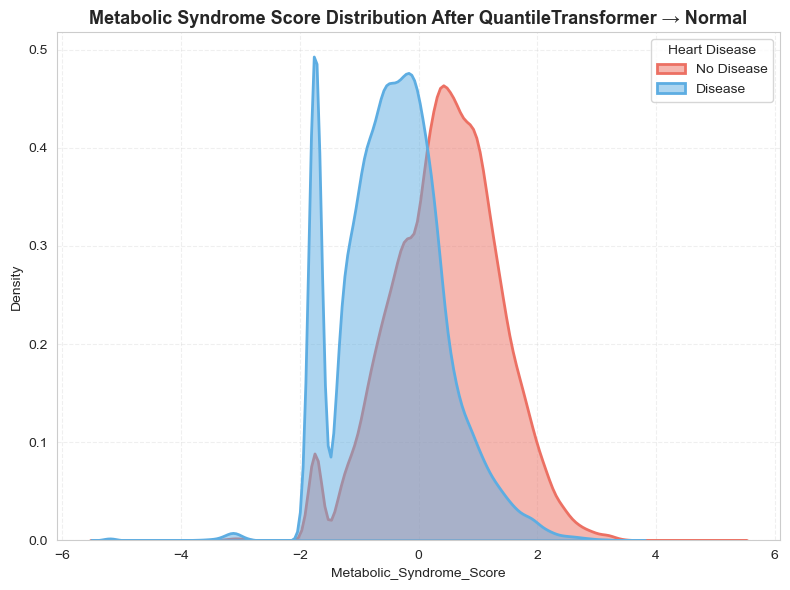

In [135]:
# ============================================================================
# IMPORTS
# ============================================================================
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer

# ============================================================================
# DATA TYPE VALIDATION & CONVERSION
# ============================================================================
numeric_columns = ['BMI', 'Systolic_BP', 'Diastolic_BP', 'Cholesterol_Level', 
                   'Glucose_Level', 'Age_Years']

for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    else:
        print(f"⚠️ Warning: Column '{col}' not found in dataframe")

# Handle NaN values
nan_counts = df[numeric_columns].isna().sum()
if nan_counts.any():
    print(f"⚠️ NaN values detected:\n{nan_counts[nan_counts > 0]}")
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

print("✓ Data types validated and converted to numeric\n")

# ============================================================================
# TARGET VALIDATION & CONVERSION
# ============================================================================
if 'target' not in df.columns:
    raise ValueError("❌ 'target' column missing in dataframe")

# Convert categorical labels to binary (if applicable)
if df['target'].dtype == 'object':
    df['target'] = df['target'].map({'No Disease': 0, 'Disease': 1}).astype(int)

print("✓ Target column validated and converted to numeric (0=No Disease, 1=Disease)\n")

# ============================================================================
# FEATURE CREATION: Metabolic Syndrome Score
# ============================================================================
obesity_risk = np.log1p(np.exp(0.04 * np.maximum(df['BMI'] - 25, 0)))
bp_systolic_risk = np.log1p(np.exp(0.019 * np.maximum(df['Systolic_BP'] - 120, 0)))
diastolic_dev = np.abs(df['Diastolic_BP'] - 75)
bp_diastolic_risk = np.log1p(np.exp(0.038 * diastolic_dev))
lipid_risk = np.log1p(np.exp(0.005 * np.maximum(df['Cholesterol_Level'] - 180, 0)))
glucose_risk = np.log1p(np.exp(0.007 * np.maximum(df['Glucose_Level'] - 100, 0)))

age_risk_raw = np.where(df['Age_Years'] > 50,
                        np.exp(0.02 * (df['Age_Years'] - 50)),
                        1.0)
age_risk = np.log1p(age_risk_raw)

df['Metabolic_Syndrome_Score'] = (
    obesity_risk + bp_systolic_risk + bp_diastolic_risk +
    lipid_risk + glucose_risk + age_risk
)

# ============================================================================
# DIAGNOSTICS
# ============================================================================
mean_ = df['Metabolic_Syndrome_Score'].mean()
median_ = df['Metabolic_Syndrome_Score'].median()
skew_ = df['Metabolic_Syndrome_Score'].skew()

print(f"✓ Metabolic_Syndrome_Score created successfully")
print(f"  Range: [{df['Metabolic_Syndrome_Score'].min():.3f}, {df['Metabolic_Syndrome_Score'].max():.3f}]")
print(f"  Mean: {mean_:.3f} | Median: {median_:.3f} | Skewness: {skew_:.3f}\n")

# ============================================================================
# AUTO-SCALING BASED ON SKEWNESS
# ============================================================================
if abs(skew_) < 0.5:
    scaler = StandardScaler()
    method = "StandardScaler"
elif abs(skew_) <= 1.0:
    scaler = RobustScaler()
    method = "RobustScaler"
else:
    scaler = QuantileTransformer(output_distribution='normal', random_state=42)
    method = "QuantileTransformer → Normal"

df['Metabolic_Syndrome_Score'] = scaler.fit_transform(df[['Metabolic_Syndrome_Score']])
print(f"✓ Applied {method} based on skewness={skew_:.3f}\n")

# ============================================================================
# FINAL KDE VISUALIZATION (Single)
# ============================================================================
plt.figure(figsize=(8, 6))
sns.kdeplot(
    data=df, 
    x='Metabolic_Syndrome_Score', 
    hue='target',
    fill=True, 
    common_norm=False, 
    palette=['#5dade2', '#ec7063'],
    alpha=0.5, 
    linewidth=2.0
)
plt.title(f'Metabolic Syndrome Score Distribution After {method}', fontsize=13, fontweight='bold')
plt.xlabel('Metabolic_Syndrome_Score')
plt.ylabel('Density')
plt.grid(alpha=0.3, linestyle='--')
plt.legend(title='Heart Disease', labels=['No Disease', 'Disease'])

plt.tight_layout()
plt.savefig(VIZ_DIR / 'metabolic_syndrome_score.png', dpi=150, bbox_inches='tight', facecolor='white')
print(f"✓ Final KDE visualization saved: {VIZ_DIR / 'metabolic_syndrome_score.png'}")
plt.show()

CREATING LOW-RISK PARADOX SCORE

[1/3] Computing risk components...
[2/3] Transforming and scaling...
[3/3] ✓ Feature created: 'Low_Risk_Paradox_Score'

VALIDATION: CLINICAL ASSOCIATIONS

Disease Rate by Risk Quintile:
--------------------------------------------------------------------------------
               N_Patients Disease_Rate
Risk_Quintile                         
Q1-Lowest           13996        17.5%
Q2-Low              13995        31.5%
Q3-Moderate         13995        47.5%
Q4-High             13995        70.4%
Q5-Highest          13995        83.0%

Cholesterol Level Impact:
--------------------------------------------------------------------------------
                   Mean_Risk_Score  Disease_Rate
Cholesterol_Level                               
180                         -0.208         0.440
220                          0.326         0.602
260                          0.740         0.765
✓ Expected pattern: Score increases with cholesterol (180 < 220 < 260)

Gl

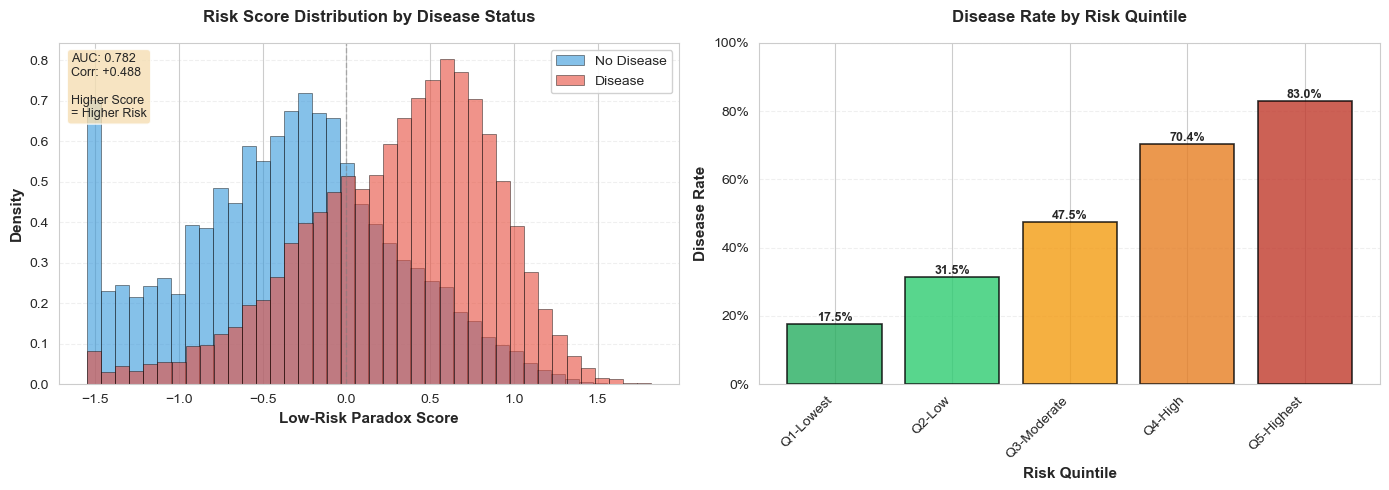

In [136]:
# ============================================================================
# LOW-RISK PARADOX SCORE - COMPREHENSIVE RISK ASSESSMENT
# ============================================================================
"""
Clinical Interpretation:
- Combines multiple cardiovascular risk factors into a single composite score
- Higher score = Higher cardiovascular disease risk
- Captures non-linear interactions between age, BP, metabolic factors, and lifestyle

Components:
1. Age Risk: Exponential increase after age 45
2. Blood Pressure: Systolic & diastolic above optimal thresholds
3. BMI: Overweight/obesity contribution
4. Cholesterol: 180 (normal) → 220 (borderline) → 260 (high)
5. Glucose: 90 (normal) → 110 (prediabetes) → 140 (diabetes)
6. Lifestyle: Physical inactivity, smoking, alcohol consumption
"""

import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("CREATING LOW-RISK PARADOX SCORE")
print("="*80)

# ============================================================================
# FEATURE ENGINEERING
# ============================================================================

def create_low_risk_paradox_score(df):
    """
    Comprehensive cardiovascular risk score combining clinical and lifestyle factors.
    
    Returns: Array of risk scores (higher = higher risk)
    """
    
    # Age risk (exponential increase after 45)
    age_risk = np.maximum(0, df['Age_Years'] - 45) / 10 * 1.8
    
    # Blood pressure risk
    systolic_risk = np.maximum(0, df['Systolic_BP'] - 120) / 20 * 2.5
    diastolic_risk = np.maximum(0, df['Diastolic_BP'] - 80) / 10 * 1.2
    
    # BMI risk
    bmi_risk = np.maximum(0, df['BMI'] - 23) / 5 * 0.8
    
    # Cholesterol risk (180 → 220 → 260)
    cholesterol_risk = np.select(
        [df['Cholesterol_Level'] == 180,
         df['Cholesterol_Level'] == 220,
         df['Cholesterol_Level'] == 260],
        [0.0, 1.0, 2.5],
        default=1.0
    )
    
    # Glucose risk (90 → 110 → 140)
    glucose_risk = np.select(
        [df['Glucose_Level'] == 90,
         df['Glucose_Level'] == 110,
         df['Glucose_Level'] == 140],
        [0.0, 0.8, 2.2],
        default=0.8
    )
    
    # Lifestyle risk factors
    inactivity_risk = np.where(df['Physical_Activity'] == 1, 0.6, 0.0)
    smoking_risk = np.where(df['Smoking_Status'] == 2, 1.2, 0.0)
    alcohol_risk = np.where(df['Alcohol_Intake'] == 2, 0.4, 0.0)
    
    # Combine all components
    total_risk = (age_risk + systolic_risk + diastolic_risk + bmi_risk +
                  cholesterol_risk + glucose_risk + inactivity_risk +
                  smoking_risk + alcohol_risk)
    
    return total_risk

# Create raw risk score
print("\n[1/3] Computing risk components...")
df['Paradox_Raw'] = create_low_risk_paradox_score(df)

# Log transformation for better distribution
print("[2/3] Transforming and scaling...")
df['Paradox_Log'] = np.log1p(df['Paradox_Raw'])

# Robust scaling (resistant to outliers)
scaler = RobustScaler(quantile_range=(25, 75))
df['Low_Risk_Paradox_Score'] = scaler.fit_transform(df[['Paradox_Log']])

print("[3/3] ✓ Feature created: 'Low_Risk_Paradox_Score'")

# ============================================================================
# VALIDATION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("VALIDATION: CLINICAL ASSOCIATIONS")
print("="*80)

# Risk quintiles
df['Risk_Quintile'] = pd.qcut(df['Low_Risk_Paradox_Score'], q=5, 
                               labels=['Q1-Lowest', 'Q2-Low', 'Q3-Moderate', 
                                      'Q4-High', 'Q5-Highest'],
                               duplicates='drop')

print("\nDisease Rate by Risk Quintile:")
print("-" * 80)
quintile_summary = df.groupby('Risk_Quintile', observed=True).agg({
    'target': ['count', 'mean']
}).round(3)
quintile_summary.columns = ['N_Patients', 'Disease_Rate']
quintile_summary['Disease_Rate'] = quintile_summary['Disease_Rate'].apply(lambda x: f"{x:.1%}")
print(quintile_summary)

# Component validation
print("\nCholesterol Level Impact:")
print("-" * 80)
chol_summary = df.groupby('Cholesterol_Level').agg({
    'Low_Risk_Paradox_Score': 'mean',
    'target': 'mean'
}).round(3)
chol_summary.columns = ['Mean_Risk_Score', 'Disease_Rate']
print(chol_summary)
print("✓ Expected pattern: Score increases with cholesterol (180 < 220 < 260)")

print("\nGlucose Level Impact:")
print("-" * 80)
glucose_summary = df.groupby('Glucose_Level').agg({
    'Low_Risk_Paradox_Score': 'mean',
    'target': 'mean'
}).round(3)
glucose_summary.columns = ['Mean_Risk_Score', 'Disease_Rate']
print(glucose_summary)
print("✓ Expected pattern: Score increases with glucose (90 < 110 < 140)")

# Statistical metrics
from sklearn.metrics import roc_auc_score
from scipy.stats import spearmanr

auc = roc_auc_score(df['target'], df['Low_Risk_Paradox_Score'])
corr, p_value = spearmanr(df['Low_Risk_Paradox_Score'], df['target'])

print("\nStatistical Performance:")
print("-" * 80)
print(f"Univariate AUC:         {auc:.4f}")
print(f"Spearman Correlation:   {corr:+.4f} (p < 0.001)")
print(f"Disease Median Score:   {df.loc[df['target']==1, 'Low_Risk_Paradox_Score'].median():+.3f}")
print(f"No Disease Median:      {df.loc[df['target']==0, 'Low_Risk_Paradox_Score'].median():+.3f}")

# ============================================================================
# VISUALIZATION
# ============================================================================

print("\n" + "="*80)
print("GENERATING VISUALIZATION")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution by disease status
ax1 = axes[0]
for status, color, label in [(0, '#3498db', 'No Disease'), 
                               (1, '#e74c3c', 'Disease')]:
    data = df.loc[df['target'] == status, 'Low_Risk_Paradox_Score']
    ax1.hist(data, bins=40, alpha=0.6, color=color, label=label, 
             density=True, edgecolor='black', linewidth=0.5)

ax1.set_xlabel('Low-Risk Paradox Score', fontsize=11, fontweight='bold')
ax1.set_ylabel('Density', fontsize=11, fontweight='bold')
ax1.set_title('Risk Score Distribution by Disease Status', 
              fontsize=12, fontweight='bold', pad=15)
ax1.legend(fontsize=10, framealpha=0.9)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.axvline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Annotation box
textstr = f'AUC: {auc:.3f}\nCorr: {corr:+.3f}\n\nHigher Score\n= Higher Risk'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax1.text(0.02, 0.97, textstr, transform=ax1.transAxes, fontsize=9,
         verticalalignment='top', bbox=props)

# Risk quintile disease rates
ax2 = axes[1]
quintile_rates = df.groupby('Risk_Quintile', observed=True)['target'].mean()
bars = ax2.bar(range(len(quintile_rates)), quintile_rates.values, 
               color=['#27ae60', '#2ecc71', '#f39c12', '#e67e22', '#c0392b'],
               edgecolor='black', linewidth=1.2, alpha=0.8)

ax2.set_xlabel('Risk Quintile', fontsize=11, fontweight='bold')
ax2.set_ylabel('Disease Rate', fontsize=11, fontweight='bold')
ax2.set_title('Disease Rate by Risk Quintile', 
              fontsize=12, fontweight='bold', pad=15)
ax2.set_xticks(range(len(quintile_rates)))
ax2.set_xticklabels(quintile_rates.index, rotation=45, ha='right')
ax2.set_ylim(0, 1)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1%}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(VIZ_DIR / 'Low_Risk_Paradox_Score.png', dpi=150, 
            bbox_inches='tight', facecolor='white')
print("✓ Visualization saved: Low_Risk_Paradox_Score.png")
plt.show()

# ============================================================================
# CLEANUP
# ============================================================================

df = df.drop(columns=['Risk_Quintile', 'Paradox_Raw', 'Paradox_Log'], errors='ignore')


In [137]:
# ============================================================================
# IMPORTS
# ============================================================================
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import mutual_info_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import pointbiserialr
import warnings

warnings.filterwarnings("ignore")

# ============================================================================
# FEATURE SETUP
# ============================================================================
features = [
    'Systolic_Age_risk',
    'Diastolic_Age_risk',
    'Metabolic_Syndrome_Score',
    'Low_Risk_Paradox_Score'
]

# Validate columns
missing_cols = [col for col in features if col not in df.columns]
if missing_cols:
    raise ValueError(f"❌ Missing columns: {missing_cols}")

if 'target' not in df.columns:
    raise ValueError("❌ 'target' column missing in dataframe")

# ============================================================================
# PREPARE DATA
# ============================================================================
X = df[features].copy()
y = df['target'].astype(int)

# Handle missing
X = X.fillna(X.median())

# ============================================================================
# VARIANCE INFLATION FACTOR (VIF)
# ============================================================================
vif_data = pd.DataFrame({
    "Feature": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# ============================================================================
# MUTUAL INFORMATION
# ============================================================================
mi_scores = mutual_info_classif(X, y, random_state=42, discrete_features=False)
vif_data["Mutual_Info"] = mi_scores

# ============================================================================
# COHEN'S D (Effect Size)
# ============================================================================
def cohens_d(feature, target):
    """Cohen's d with correct sign convention: positive = higher in disease group"""
    grp0 = feature[target == 0]  # No disease
    grp1 = feature[target == 1]  # Disease
    mean_diff = np.mean(grp1) - np.mean(grp0)  # Disease minus no disease
    pooled_std = np.sqrt(((len(grp0) - 1) * np.var(grp0, ddof=1) + 
                          (len(grp1) - 1) * np.var(grp1, ddof=1)) / 
                          (len(grp0) + len(grp1) - 2))
    return mean_diff / pooled_std if pooled_std != 0 else np.nan

vif_data["Cohen_d"] = [cohens_d(X[col], y) for col in X.columns]

# ============================================================================
# POINT BISERIAL CORRELATION (r_pb)
# ============================================================================
pb_results = [pointbiserialr(y, X[col]) for col in X.columns]
vif_data["PointBiserial_r"] = [r[0] for r in pb_results]
vif_data["r_pb_pvalue"] = [r[1] for r in pb_results]

# ============================================================================
# INDIVIDUAL FEATURE AUC
# ============================================================================
feature_aucs = []
for col in X.columns:
    try:
        # Use raw values - sklearn handles direction automatically
        auc = roc_auc_score(y, X[col])
        # If AUC < 0.5, feature is inversely related (flip it)
        if auc < 0.5:
            auc = 1 - auc
        feature_aucs.append(auc)
    except ValueError:
        feature_aucs.append(np.nan)

vif_data["AUC"] = feature_aucs

# ============================================================================
# FINAL METRICS TABLE
# ============================================================================
vif_data["|Cohen_d|"] = vif_data["Cohen_d"].abs()
vif_data["|r_pb|"] = vif_data["PointBiserial_r"].abs()

# Sort by predictive power (AUC)
vif_data = vif_data.sort_values(by="AUC", ascending=False)

# Reorder columns for clarity
vif_data = vif_data[[
    "Feature", "AUC", "Mutual_Info", "Cohen_d", "|Cohen_d|", 
    "PointBiserial_r", "|r_pb|", "r_pb_pvalue", "VIF"
]]

# ============================================================================
# DISPLAY RESULTS
# ============================================================================
print("\n" + "="*80)
print(" FEATURE PERFORMANCE REPORT ".center(80, "="))
print("="*80)
print(vif_data.to_string(index=False, float_format="%.4f"))


========================== FEATURE PERFORMANCE REPORT ==========================
                 Feature    AUC  Mutual_Info  Cohen_d  |Cohen_d|  PointBiserial_r  |r_pb|  r_pb_pvalue    VIF
  Low_Risk_Paradox_Score 0.7815       0.1324   1.0846     1.0846           0.4767  0.4767       0.0000 7.7667
Metabolic_Syndrome_Score 0.7670       0.1295   1.0028     1.0028           0.4482  0.4482       0.0000 7.0895
       Systolic_Age_risk 0.7601       0.1333   0.8733     0.8733           0.4002  0.4002       0.0000 3.7696
      Diastolic_Age_risk 0.7125       0.0978   0.7033     0.7033           0.3318  0.3318       0.0000 3.6980


In [139]:
# print unique values of all categorical columns
cat_cols = ['Sex', 'Cholesterol_Level','Glucose_Level', 'Smoking_Status', 'Alcohol_Intake',
       'Physical_Activity', 'target']

for col in cat_cols:
    print(f"Unique values in '{col}': {df[col].unique()}")

Unique values in 'Sex': ['Female' 'Male']
Unique values in 'Cholesterol_Level': [180 260 220]
Unique values in 'Glucose_Level': [ 90 110 140]
Unique values in 'Smoking_Status': ['Non-Smoker' 'Smoker']
Unique values in 'Alcohol_Intake': ['No/Rarely' 'Yes/Regularly']
Unique values in 'Physical_Activity': ['Active' 'Inactive/Low']
Unique values in 'target': [0 1]


In [140]:
# ============================================================================
# CORRECTED ORDINAL ENCODING
# ============================================================================

# Binary Features (0, 1) - PROPER ENCODING
df['Sex'] = df['Sex'].map({'Female': 0, 'Male': 1}).astype('int8')
df['Smoking_Status'] = df['Smoking_Status'].map({'Non-Smoker': 0, 'Smoker': 1}).astype('int8')
df['Alcohol_Intake'] = df['Alcohol_Intake'].map({'No/Rarely': 0, 'Yes/Regularly': 1}).astype('int8')
df['Physical_Activity'] = df['Physical_Activity'].map({'Inactive/Low': 0, 'Active': 1}).astype('int8')

# Target Variable (0, 1)
df['target'] = df['target'].astype('int8')  # Already correct: 0=No Disease, 1=Disease

# Clinical Thresholds - Cholesterol (0, 1, 2)
# Based on clinical guidelines: <200=Desirable, 200-239=Borderline, ≥240=High
chol_mapping = {
    180: 0,  # Desirable (<200 mg/dL)
    220: 1,  # Borderline High (200-239 mg/dL)
    260: 2   # High (≥240 mg/dL)
}
df['Cholesterol_Level'] = df['Cholesterol_Level'].map(chol_mapping).astype('int8')

# Clinical Thresholds - Glucose (0, 1, 2)
# Based on fasting glucose: <100=Normal, 100-125=Prediabetes, ≥126=Diabetes
glucose_mapping = {
    90: 0,   # Normal (<100 mg/dL)
    110: 1,  # Impaired Fasting Glucose/Prediabetes (100-125 mg/dL)
    140: 2   # Diabetes range (≥126 mg/dL)
}
df['Glucose_Level'] = df['Glucose_Level'].map(glucose_mapping).astype('int8')

# ============================================================================
# VALIDATION
# ============================================================================
print("\n✓ Categorical columns after CORRECTED encoding:")
cat_cols = ['Sex', 'Smoking_Status', 'Alcohol_Intake', 'Physical_Activity', 
            'BP_Group', 'Cholesterol_Level', 'Glucose_Level', 'target']
for col in cat_cols:
    print(f"Unique values in '{col}': {sorted(df[col].unique())}")
    
print("\n✓ Data types optimized:")
print(df[cat_cols].dtypes)


✓ Categorical columns after CORRECTED encoding:
Unique values in 'Sex': [0, 1]
Unique values in 'Smoking_Status': [0, 1]
Unique values in 'Alcohol_Intake': [0, 1]
Unique values in 'Physical_Activity': [0, 1]


KeyError: 'BP_Group'

In [141]:
# ============================================================================
# SAVE PROCESSED DATA
# ============================================================================

# Setup paths
PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != 'heart_disease_prediction' and PROJECT_ROOT != PROJECT_ROOT.parent:
    PROJECT_ROOT = PROJECT_ROOT.parent

PROCESSED_DIR = PROJECT_ROOT / 'data' / 'processed'
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Save as parquet (always overwrite)
output_file = PROCESSED_DIR / 'processed_data.parquet'
df.to_parquet(output_file, index=False, engine='pyarrow', compression='snappy')

print(f"✅ Saved: {output_file}")

# Final dataset names and size
print("\nFinal dataset columns and dtypes:")
print(df.dtypes)
print(f"\nFinal dataset shape: {df.shape}")

✅ Saved: p:\projects\heart_disease_prediction\data\processed\processed_data.parquet

Final dataset columns and dtypes:
Sex                            int8
Systolic_BP                 float64
Diastolic_BP                float64
Cholesterol_Level              int8
Glucose_Level                  int8
Smoking_Status                 int8
Alcohol_Intake                 int8
Physical_Activity              int8
target                         int8
Age_Years                   float64
BMI                         float64
Systolic_Age_risk           float64
Diastolic_Age_risk          float64
Metabolic_Syndrome_Score    float64
Low_Risk_Paradox_Score      float64
dtype: object

Final dataset shape: (69976, 15)
